In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import SCRIPT_KERAS_TO_TENSORFLOW 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(SCRIPT_KERAS_TO_TENSORFLOW)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
C:/keras_to_tensorflow/keras_to_tensorflow.py
(224, 224)
42
6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.4578 - accuracy: 0.8193 - precision: 0.9610 - recall: 0.8284 - f1: 0.8808 - specificity: 0.7430 - negative_predictive_value: 0.3355 - matthews_correlation_coefficient: 0.4045 - val_loss: 0.3823 - val_accuracy: 0.8968 - val_precision: 0.9772 - val_recall: 0.9112 - val_f1: 0.9421 - val_specificity: 0.6977 - val_negative_predictive_value: 0.4276 - val_matthews_correlation_coefficient: 0.4892

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.48921, saving model to ../models/autoencoders_requirements/blurred_2020_03_21-11_42_33.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3911 - accuracy: 0.8742 - precision: 0.9760 - recall: 0.8851 - f1: 0.9272 - specificity: 0.7251 - negative_predictive_value: 0.3812 - matthews_correlation_coefficient: 0.4588 - val_loss: 0.3953 - val_accuracy: 0.8985 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.54116
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3304 - accuracy: 0.8542 - precision: 0.9844 - recall: 0.8554 - f1: 0.9136 - specificity: 0.7960 - negative_predictive_value: 0.3626 - matthews_correlation_coefficient: 0.4675 - val_loss: 0.2852 - val_accuracy: 0.8873 - val_precision: 0.9816 - val_recall: 0.8958 - val_f1: 0.9356 - val_specificity: 0.7311 - val_negative_predictive_value: 0.4093 - val_matthews_correlation_coefficient: 0.4898

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.54116
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3173 - accuracy: 0.8662 - precision: 0.9848 - recall: 0.8676 - f1: 0.9205 - specificity: 0.8318 - negative_predictive_value: 0.3939 - matthews_correlation_coefficient: 0.5035 - val_loss: 0.2647 - val_accuracy: 0.9115 - val_precision: 0.9805 - val_recall: 0.9241 - val_f1: 0.9506 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.55592
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3129 - accuracy: 0.8564 - precision: 0.9880 - recall: 0.8508 - f1: 0.9115 - specificity: 0.8346 - negative_predictive_value: 0.3786 - matthews_correlation_coefficient: 0.4952 - val_loss: 0.2243 - val_accuracy: 0.9185 - val_precision: 0.9808 - val_recall: 0.9316 - val_f1: 0.9547 - val_specificity: 0.7176 - val_negative_predictive_value: 0.4901 - val_matthews_correlation_coefficient: 0.5444

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.55592
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2957 - accuracy: 0.8664 - precision: 0.9877 - recall: 0.8618 - f1: 0.9183 - specificity: 0.8644 - negative_predictive_value: 0.4051 - matthews_correlation_coefficient: 0.5245 - val_loss: 0.2011 - val_accuracy: 0.9297 - val_precision: 0.9764 - val_recall: 0.9482 - val_f1: 0.9613 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.56762
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2960 - accuracy: 0.8803 - precision: 0.9882 - recall: 0.8807 - f1: 0.9296 - specificity: 0.8561 - negative_predictive_value: 0.4323 - matthews_correlation_coefficient: 0.5440 - val_loss: 0.2798 - val_accuracy: 0.8916 - val_precision: 0.9845 - val_recall: 0.8978 - val_f1: 0.9383 - val_specificity: 0.7486 - val_negative_predictive_value: 0.4061 - val_matthews_correlation_coefficient: 0.4990

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.56762
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2969 - accuracy: 0.8777 - precision: 0.9897 - recall: 0.8731 - f1: 0.9260 - specificity: 0.8303 - negative_predictive_value: 0.4084 - matthews_correlation_coefficient: 0.5237 - val_loss: 0.2512 - val_accuracy: 0.9089 - val_precision: 0.9833 - val_recall: 0.9183 - val_f1: 0.9486 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.58661
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2733 - accuracy: 0.8824 - precision: 0.9893 - recall: 0.8817 - f1: 0.9308 - specificity: 0.8735 - negative_predictive_value: 0.4372 - matthews_correlation_coefficient: 0.5574 - val_loss: 0.1635 - val_accuracy: 0.9436 - val_precision: 0.9759 - val_recall: 0.9640 - val_f1: 0.9693 - val_specificity: 0.6752 - val_negative_predictive_value: 0.6108 - val_matthews_correlation_coefficient: 0.6026

Epoch 00060: val_matthews_correlation_coefficient improved from 0.58661 to 0.60265, saving model to ../models/autoencoders_requirements/blurred_2020_03_21-11_42_33.h5
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2794 - accuracy: 0.8881 - precision: 0.9882 - recall: 0.8883 - f1: 0.9340 - specificity: 0.8021 - negative_predictive_value: 0.4247 - matthews_correlation_coefficient: 0.5251 - val_loss: 0.2559 - val_


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.60265
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2644 - accuracy: 0.8876 - precision: 0.9914 - recall: 0.8852 - f1: 0.9340 - specificity: 0.8413 - negative_predictive_value: 0.4238 - matthews_correlation_coefficient: 0.5410 - val_loss: 0.2616 - val_accuracy: 0.8925 - val_precision: 0.9878 - val_recall: 0.8959 - val_f1: 0.9385 - val_specificity: 0.7685 - val_negative_predictive_value: 0.4253 - val_matthews_correlation_coefficient: 0.5205

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.60265
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2681 - accuracy: 0.8833 - precision: 0.9903 - recall: 0.8817 - f1: 0.9313 - specificity: 0.8767 - negative_predictive_value: 0.4351 - matthews_correlation_coefficient: 0.5575 - val_loss: 0.2319 - val_accuracy: 0.9185 - val_precision: 0.9845 - val_recall: 0.9276 - val_f1: 0.9544 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.60265
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2529 - accuracy: 0.8926 - precision: 0.9901 - recall: 0.8923 - f1: 0.9374 - specificity: 0.8505 - negative_predictive_value: 0.4450 - matthews_correlation_coefficient: 0.5589 - val_loss: 0.2138 - val_accuracy: 0.9193 - val_precision: 0.9825 - val_recall: 0.9303 - val_f1: 0.9548 - val_specificity: 0.7275 - val_negative_predictive_value: 0.5051 - val_matthews_correlation_coefficient: 0.5618
Restoring model weights from the end of the best epoch

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.60265
Epoch 00090: early stopping

   Final Accuracy:  94.36%
  Final Precision:  97.50%
     Final Recall:  96.29%
  Final F-measure:  96.89%
Final Specificity:  74.26%
        Final NPV:  65.79%
        Final MCC:  66.82%
[[  75   26]
 [  39 1013]]
              precision    recall  f1-score   support

           0 

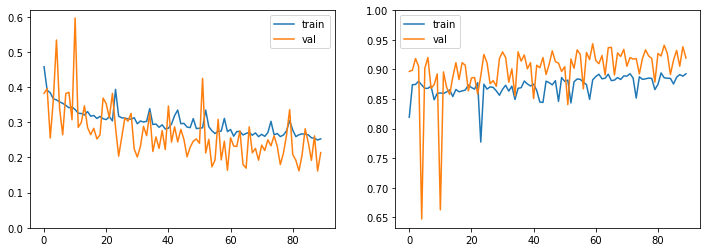

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6729 - accuracy: 0.5813 - precision: 0.7816 - recall: 0.5639 - f1: 0.6275 - specificity: 0.6139 - negative_predictive_value: 0.3974 - matthews_correlation_coefficient: 0.1765 - val_loss: 0.6387 - val_accuracy: 0.6071 - val_precision: 0.8114 - val_recall: 0.5267 - val_f1: 0.6344 - val_specificity: 0.7340 - val_negative_predictive_value: 0.4054 - val_matthews_correlation_coefficient: 0.2633

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26333, saving model to ../models/autoencoders_requirements/looking_away_2020_03_21-11_55_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6635 - accuracy: 0.6082 - precision: 0.7785 - recall: 0.6061 - f1: 0.6721 - specificity: 0.6140 - negative_predictive_value: 0.4119 - matthews_correlation_coefficient: 0.2059 - val_loss: 0.6658 - val_accuracy: 0.5768 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6279 - accuracy: 0.6586 - precision: 0.8236 - recall: 0.6591 - f1: 0.7189 - specificity: 0.6520 - negative_predictive_value: 0.4599 - matthews_correlation_coefficient: 0.2969 - val_loss: 0.5858 - val_accuracy: 0.6782 - val_precision: 0.7465 - val_recall: 0.7494 - val_f1: 0.7452 - val_specificity: 0.4509 - val_negative_predictive_value: 0.4453 - val_matthews_correlation_coefficient: 0.2218

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34643
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6246 - accuracy: 0.6577 - precision: 0.8196 - recall: 0.6604 - f1: 0.7224 - specificity: 0.6627 - negative_predictive_value: 0.4632 - matthews_correlation_coefficient: 0.3012 - val_loss: 0.5640 - val_accuracy: 0.7138 - val_precision: 0.7628 - val_recall: 0.7900 - val_f1: 0.7741 - val_specificity: 0.4677 - val_negative_predictive_value: 0.4948 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5918 - accuracy: 0.6950 - precision: 0.8302 - recall: 0.7148 - f1: 0.7604 - specificity: 0.6648 - negative_predictive_value: 0.5118 - matthews_correlation_coefficient: 0.3587 - val_loss: 0.6611 - val_accuracy: 0.6522 - val_precision: 0.8317 - val_recall: 0.5844 - val_f1: 0.6841 - val_specificity: 0.7433 - val_negative_predictive_value: 0.4382 - val_matthews_correlation_coefficient: 0.3230

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37694
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5907 - accuracy: 0.6933 - precision: 0.8270 - recall: 0.6982 - f1: 0.7510 - specificity: 0.6684 - negative_predictive_value: 0.4954 - matthews_correlation_coefficient: 0.3428 - val_loss: 0.5874 - val_accuracy: 0.6912 - val_precision: 0.8249 - val_recall: 0.6623 - val_f1: 0.7316 - val_specificity: 0.6922 - val_negative_predictive_value: 0.4750 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.37699
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5687 - accuracy: 0.7104 - precision: 0.8466 - recall: 0.7208 - f1: 0.7726 - specificity: 0.6966 - negative_predictive_value: 0.5262 - matthews_correlation_coefficient: 0.3929 - val_loss: 0.6451 - val_accuracy: 0.6427 - val_precision: 0.8529 - val_recall: 0.5537 - val_f1: 0.6649 - val_specificity: 0.7789 - val_negative_predictive_value: 0.4327 - val_matthews_correlation_coefficient: 0.3332

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37699
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5768 - accuracy: 0.7065 - precision: 0.8412 - recall: 0.7235 - f1: 0.7709 - specificity: 0.6808 - negative_predictive_value: 0.5238 - matthews_correlation_coefficient: 0.3818 - val_loss: 0.6339 - val_accuracy: 0.6661 - val_precision: 0.8535 - val_recall: 0.5918 - val_f1: 0.6940 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5598 - accuracy: 0.7176 - precision: 0.8364 - recall: 0.7280 - f1: 0.7727 - specificity: 0.6850 - negative_predictive_value: 0.5299 - matthews_correlation_coefficient: 0.3944 - val_loss: 0.5629 - val_accuracy: 0.7207 - val_precision: 0.8265 - val_recall: 0.7109 - val_f1: 0.7611 - val_specificity: 0.6694 - val_negative_predictive_value: 0.5047 - val_matthews_correlation_coefficient: 0.3806

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.38914
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.7158 - precision: 0.8387 - recall: 0.7262 - f1: 0.7712 - specificity: 0.6930 - negative_predictive_value: 0.5309 - matthews_correlation_coefficient: 0.3913 - val_loss: 0.6641 - val_accuracy: 0.6444 - val_precision: 0.8661 - val_recall: 0.5463 - val_f1: 0.6653 - val_specificity: 0.8112 - val_negative_predictive_value: 0.4358 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5564 - accuracy: 0.7230 - precision: 0.8546 - recall: 0.7245 - f1: 0.7768 - specificity: 0.7114 - negative_predictive_value: 0.5417 - matthews_correlation_coefficient: 0.4157 - val_loss: 0.6064 - val_accuracy: 0.6592 - val_precision: 0.8449 - val_recall: 0.5877 - val_f1: 0.6883 - val_specificity: 0.7589 - val_negative_predictive_value: 0.4473 - val_matthews_correlation_coefficient: 0.3437

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.40926
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5591 - accuracy: 0.7100 - precision: 0.8371 - recall: 0.7156 - f1: 0.7637 - specificity: 0.6883 - negative_predictive_value: 0.5290 - matthews_correlation_coefficient: 0.3847 - val_loss: 0.7516 - val_accuracy: 0.6227 - val_precision: 0.8562 - val_recall: 0.5148 - val_f1: 0.6376 - val_specificity: 0.8140 - val_negative_predictive_value: 0.4218 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5476 - accuracy: 0.7182 - precision: 0.8572 - recall: 0.7228 - f1: 0.7740 - specificity: 0.7011 - negative_predictive_value: 0.5351 - matthews_correlation_coefficient: 0.4070 - val_loss: 0.5886 - val_accuracy: 0.6834 - val_precision: 0.8411 - val_recall: 0.6293 - val_f1: 0.7165 - val_specificity: 0.7385 - val_negative_predictive_value: 0.4678 - val_matthews_correlation_coefficient: 0.3627

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.40926
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5478 - accuracy: 0.7273 - precision: 0.8492 - recall: 0.7463 - f1: 0.7883 - specificity: 0.6893 - negative_predictive_value: 0.5428 - matthews_correlation_coefficient: 0.4106 - val_loss: 0.6108 - val_accuracy: 0.6791 - val_precision: 0.8693 - val_recall: 0.5959 - val_f1: 0.7029 - val_specificity: 0.8039 - val_negative_predictive_value: 0.4655 - val_matthews_correlation_coefficie

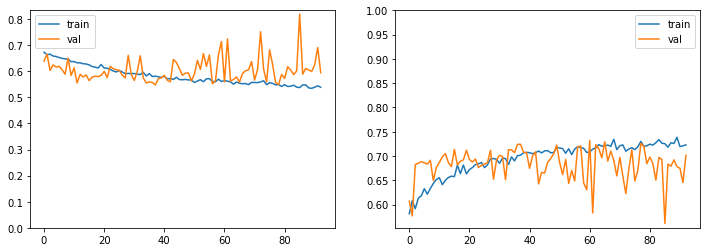

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.8441 - accuracy: 0.7375 - precision: 0.9300 - recall: 0.7402 - f1: 0.7747 - specificity: 0.0069 - negative_predictive_value: 3.6298e-04 - matthews_correlation_coefficient: 0.0010 - val_loss: 0.0139 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 1.0000 - val_f1: 0.9991 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/ink_marked_creased_2020_03_21-12_09_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 1.5701 - accuracy: 0.9028 - precision: 0.9986 - recall: 0.9014 - f1: 0.9305 - specificity: 0.0000e+00 - negative_predictive_value: 0.0000e+00 - matthews_correlation_coefficient: -9.5946e-04 - val_loss: 0.8826 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6958 - accuracy: 0.5690 - precision: 0.9992 - recall: 0.5688 - f1: 0.7028 - specificity: 0.0138 - negative_predictive_value: 0.0022 - matthews_correlation_coefficient: 0.0028 - val_loss: 0.6827 - val_accuracy: 0.6253 - val_precision: 0.9718 - val_recall: 0.6093 - val_f1: 0.7459 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0023 - val_matthews_correlation_coefficient: 0.0035

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.00346
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6724 - accuracy: 0.7180 - precision: 0.9989 - recall: 0.7205 - f1: 0.8315 - specificity: 0.0138 - negative_predictive_value: 0.0057 - matthews_correlation_coefficient: 0.0062 - val_loss: 0.6568 - val_accuracy: 0.6496 - val_precision: 0.9718 - val_recall: 0.6330 - val_f1: 0.7635 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0025 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5589 - accuracy: 0.7508 - precision: 0.9992 - recall: 0.7493 - f1: 0.8193 - specificity: 0.0207 - negative_predictive_value: 0.0011 - matthews_correlation_coefficient: 0.0021 - val_loss: 1.0119 - val_accuracy: 0.2507 - val_precision: 0.9705 - val_recall: 0.2437 - val_f1: 0.3844 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0011 - val_matthews_correlation_coefficient: -0.0039

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.00487
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5974 - accuracy: 0.4846 - precision: 0.9993 - recall: 0.4845 - f1: 0.6326 - specificity: 0.0207 - negative_predictive_value: 0.0018 - matthews_correlation_coefficient: 0.0026 - val_loss: 0.5700 - val_accuracy: 0.7008 - val_precision: 0.9708 - val_recall: 0.6837 - val_f1: 0.7996 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.00620
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4965 - accuracy: 0.7341 - precision: 0.9995 - recall: 0.7358 - f1: 0.8411 - specificity: 0.0207 - negative_predictive_value: 0.0024 - matthews_correlation_coefficient: 0.0044 - val_loss: 0.3767 - val_accuracy: 0.8144 - val_precision: 0.9711 - val_recall: 0.7946 - val_f1: 0.8723 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.0034

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.00620
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6814 - accuracy: 0.7388 - precision: 0.9923 - recall: 0.7345 - f1: 0.8328 - specificity: 0.0207 - negative_predictive_value: 0.0044 - matthews_correlation_coefficient: 0.0071 - val_loss: 1.2107 - val_accuracy: 0.2394 - val_precision: 0.9707 - val_recall: 0.2328 - val_f1: 0.3714 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5620 - accuracy: 0.7362 - precision: 0.9995 - recall: 0.7382 - f1: 0.8315 - specificity: 0.0276 - negative_predictive_value: 0.0064 - matthews_correlation_coefficient: 0.0108 - val_loss: 0.7388 - val_accuracy: 0.5750 - val_precision: 0.9718 - val_recall: 0.5602 - val_f1: 0.7067 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0021 - val_matthews_correlation_coefficient: 0.0028

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.00620
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4640 - accuracy: 0.7406 - precision: 0.9998 - recall: 0.7421 - f1: 0.8413 - specificity: 0.0345 - negative_predictive_value: 0.0037 - matthews_correlation_coefficient: 0.0094 - val_loss: 0.4006 - val_accuracy: 0.8317 - val_precision: 0.9711 - val_recall: 0.8115 - val_f1: 0.8826 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_c

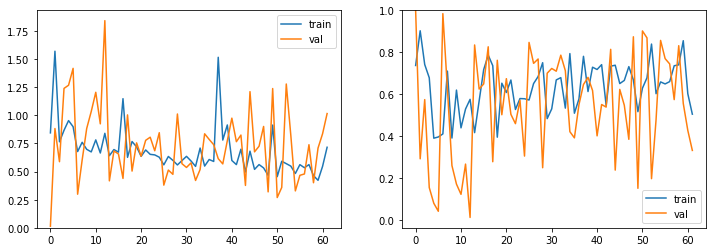

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6445 - accuracy: 0.6139 - precision: 0.6770 - recall: 0.5398 - f1: 0.5804 - specificity: 0.7030 - negative_predictive_value: 0.5777 - matthews_correlation_coefficient: 0.2549 - val_loss: 0.6376 - val_accuracy: 0.6323 - val_precision: 0.6567 - val_recall: 0.6906 - val_f1: 0.6683 - val_specificity: 0.5538 - val_negative_predictive_value: 0.5891 - val_matthews_correlation_coefficient: 0.2450

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24502, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-12_18_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6119 - accuracy: 0.6501 - precision: 0.7117 - recall: 0.6238 - f1: 0.6362 - specificity: 0.6846 - negative_predictive_value: 0.6371 - matthews_correlation_coefficient: 0.3265 - val_loss: 0.6225 - val_accuracy: 0.6487 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5076 - accuracy: 0.7275 - precision: 0.7541 - recall: 0.7452 - f1: 0.7408 - specificity: 0.7127 - negative_predictive_value: 0.7152 - matthews_correlation_coefficient: 0.4629 - val_loss: 0.5231 - val_accuracy: 0.7225 - val_precision: 0.7178 - val_recall: 0.8192 - val_f1: 0.7602 - val_specificity: 0.5948 - val_negative_predictive_value: 0.7234 - val_matthews_correlation_coefficient: 0.4269

Epoch 00015: val_matthews_correlation_coefficient improved from 0.40587 to 0.42695, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-12_18_38.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5096 - accuracy: 0.7252 - precision: 0.7421 - recall: 0.7425 - f1: 0.7344 - specificity: 0.7031 - negative_predictive_value: 0.7058 - matthews_correlation_coefficient: 0.4534 - val_loss: 0.5218 - val_accuracy: 0.7121 - val_precision: 0.7214 - val_recall: 0.7853 - val_f1: 0.7453 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4750 - accuracy: 0.7425 - precision: 0.7682 - recall: 0.7513 - f1: 0.7517 - specificity: 0.7320 - negative_predictive_value: 0.7165 - matthews_correlation_coefficient: 0.4854 - val_loss: 0.4959 - val_accuracy: 0.7424 - val_precision: 0.7487 - val_recall: 0.8058 - val_f1: 0.7712 - val_specificity: 0.6572 - val_negative_predictive_value: 0.7194 - val_matthews_correlation_coefficient: 0.4653

Epoch 00029: val_matthews_correlation_coefficient improved from 0.46374 to 0.46535, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-12_18_38.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4921 - accuracy: 0.7364 - precision: 0.7658 - recall: 0.7472 - f1: 0.7443 - specificity: 0.7306 - negative_predictive_value: 0.7248 - matthews_correlation_coefficient: 0.4837 - val_loss: 0.4888 - val_accuracy: 0.7346 - val_precision: 0.7769 - val_recall: 0.7293 - val_f1: 0.7444 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4653 - accuracy: 0.7549 - precision: 0.7859 - recall: 0.7630 - f1: 0.7629 - specificity: 0.7471 - negative_predictive_value: 0.7326 - matthews_correlation_coefficient: 0.5156 - val_loss: 0.5083 - val_accuracy: 0.7433 - val_precision: 0.7352 - val_recall: 0.8408 - val_f1: 0.7785 - val_specificity: 0.6177 - val_negative_predictive_value: 0.7485 - val_matthews_correlation_coefficient: 0.4704

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.48645
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4686 - accuracy: 0.7612 - precision: 0.7904 - recall: 0.7665 - f1: 0.7679 - specificity: 0.7541 - negative_predictive_value: 0.7388 - matthews_correlation_coefficient: 0.5261 - val_loss: 0.5031 - val_accuracy: 0.7389 - val_precision: 0.7485 - val_recall: 0.7904 - val_f1: 0.7643 - val_specificity: 0.6614 - val_negative_predictive_value: 0.7108 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4499 - accuracy: 0.7725 - precision: 0.7900 - recall: 0.7774 - f1: 0.7767 - specificity: 0.7640 - negative_predictive_value: 0.7518 - matthews_correlation_coefficient: 0.5429 - val_loss: 0.4835 - val_accuracy: 0.7363 - val_precision: 0.8229 - val_recall: 0.6632 - val_f1: 0.7252 - val_specificity: 0.8081 - val_negative_predictive_value: 0.6587 - val_matthews_correlation_coefficient: 0.4756

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48645
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4465 - accuracy: 0.7746 - precision: 0.7982 - recall: 0.7707 - f1: 0.7769 - specificity: 0.7818 - negative_predictive_value: 0.7499 - matthews_correlation_coefficient: 0.5519 - val_loss: 0.4824 - val_accuracy: 0.7329 - val_precision: 0.7917 - val_recall: 0.6985 - val_f1: 0.7336 - val_specificity: 0.7616 - val_negative_predictive_value: 0.6708 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4402 - accuracy: 0.7727 - precision: 0.7887 - recall: 0.7940 - f1: 0.7827 - specificity: 0.7533 - negative_predictive_value: 0.7540 - matthews_correlation_coefficient: 0.5463 - val_loss: 0.4889 - val_accuracy: 0.7285 - val_precision: 0.7889 - val_recall: 0.6804 - val_f1: 0.7244 - val_specificity: 0.7690 - val_negative_predictive_value: 0.6625 - val_matthews_correlation_coefficient: 0.4501

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.49480
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4390 - accuracy: 0.7800 - precision: 0.7982 - recall: 0.7788 - f1: 0.7804 - specificity: 0.7791 - negative_predictive_value: 0.7652 - matthews_correlation_coefficient: 0.5604 - val_loss: 0.4704 - val_accuracy: 0.7572 - val_precision: 0.7508 - val_recall: 0.8358 - val_f1: 0.7860 - val_specificity: 0.6521 - val_negative_predictive_value: 0.7555 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.50835
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4429 - accuracy: 0.7787 - precision: 0.7949 - recall: 0.7974 - f1: 0.7880 - specificity: 0.7583 - negative_predictive_value: 0.7606 - matthews_correlation_coefficient: 0.5570 - val_loss: 0.4633 - val_accuracy: 0.7598 - val_precision: 0.8027 - val_recall: 0.7405 - val_f1: 0.7638 - val_specificity: 0.7688 - val_negative_predictive_value: 0.7039 - val_matthews_correlation_coefficient: 0.5076

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.50835
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4195 - accuracy: 0.7896 - precision: 0.8095 - recall: 0.7813 - f1: 0.7893 - specificity: 0.7981 - negative_predictive_value: 0.7671 - matthews_correlation_coefficient: 0.5778 - val_loss: 0.4733 - val_accuracy: 0.7572 - val_precision: 0.7948 - val_recall: 0.7496 - val_f1: 0.7648 - val_spe

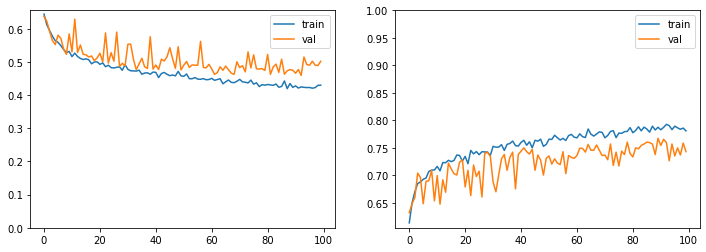

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6451 - accuracy: 0.6421 - precision: 0.9300 - recall: 0.6537 - f1: 0.7419 - specificity: 0.5812 - negative_predictive_value: 0.1779 - matthews_correlation_coefficient: 0.1606 - val_loss: 0.6219 - val_accuracy: 0.6592 - val_precision: 0.9046 - val_recall: 0.6498 - val_f1: 0.7543 - val_specificity: 0.5833 - val_negative_predictive_value: 0.1720 - val_matthews_correlation_coefficient: 0.1630

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.16298, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_21-12_33_19.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5889 - accuracy: 0.6688 - precision: 0.9464 - recall: 0.6620 - f1: 0.7651 - specificity: 0.6903 - negative_predictive_value: 0.2223 - matthews_correlation_coefficient: 0.2350 - val_loss: 0.5782 - val_accuracy: 0.6878 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5064 - accuracy: 0.7254 - precision: 0.9643 - recall: 0.7211 - f1: 0.8162 - specificity: 0.7456 - negative_predictive_value: 0.2638 - matthews_correlation_coefficient: 0.3191 - val_loss: 0.4773 - val_accuracy: 0.7433 - val_precision: 0.9256 - val_recall: 0.7291 - val_f1: 0.8143 - val_specificity: 0.6893 - val_negative_predictive_value: 0.2598 - val_matthews_correlation_coefficient: 0.2748

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.31621
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5040 - accuracy: 0.7200 - precision: 0.9632 - recall: 0.7177 - f1: 0.8158 - specificity: 0.7515 - negative_predictive_value: 0.2627 - matthews_correlation_coefficient: 0.3188 - val_loss: 0.4744 - val_accuracy: 0.7285 - val_precision: 0.9349 - val_recall: 0.7046 - val_f1: 0.8022 - val_specificity: 0.7408 - val_negative_predictive_value: 0.2605 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38439
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4597 - accuracy: 0.7557 - precision: 0.9685 - recall: 0.7533 - f1: 0.8437 - specificity: 0.7466 - negative_predictive_value: 0.2808 - matthews_correlation_coefficient: 0.3493 - val_loss: 0.4434 - val_accuracy: 0.7762 - val_precision: 0.9374 - val_recall: 0.7566 - val_f1: 0.8363 - val_specificity: 0.7428 - val_negative_predictive_value: 0.3026 - val_matthews_correlation_coefficient: 0.3420

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38439
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4576 - accuracy: 0.7579 - precision: 0.9701 - recall: 0.7514 - f1: 0.8431 - specificity: 0.7953 - negative_predictive_value: 0.2883 - matthews_correlation_coefficient: 0.3702 - val_loss: 0.4007 - val_accuracy: 0.8179 - val_precision: 0.9354 - val_recall: 0.8060 - val_f1: 0.8646 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38439
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4442 - accuracy: 0.7573 - precision: 0.9712 - recall: 0.7507 - f1: 0.8417 - specificity: 0.8049 - negative_predictive_value: 0.3034 - matthews_correlation_coefficient: 0.3835 - val_loss: 0.3766 - val_accuracy: 0.8369 - val_precision: 0.9283 - val_recall: 0.8345 - val_f1: 0.8778 - val_specificity: 0.6662 - val_negative_predictive_value: 0.3708 - val_matthews_correlation_coefficient: 0.3799

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.38439
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4344 - accuracy: 0.7761 - precision: 0.9680 - recall: 0.7737 - f1: 0.8556 - specificity: 0.7848 - negative_predictive_value: 0.3141 - matthews_correlation_coefficient: 0.3893 - val_loss: 0.3897 - val_accuracy: 0.7997 - val_precision: 0.9320 - val_recall: 0.7885 - val_f1: 0.8530 - val_spe

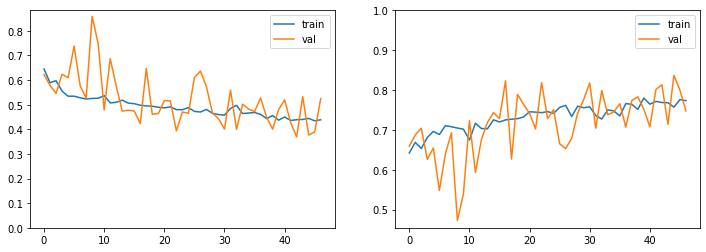

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6426 - accuracy: 0.7718 - precision: 0.9865 - recall: 0.7794 - f1: 0.8595 - specificity: 0.2437 - negative_predictive_value: 0.0375 - matthews_correlation_coefficient: 0.0618 - val_loss: 0.5590 - val_accuracy: 0.6826 - val_precision: 0.9975 - val_recall: 0.6852 - val_f1: 0.8098 - val_specificity: 0.5000 - val_negative_predictive_value: 0.0573 - val_matthews_correlation_coefficient: 0.1305

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.13047, saving model to ../models/autoencoders_requirements/washed_out_2020_03_21-12_40_22.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5692 - accuracy: 0.6430 - precision: 0.9941 - recall: 0.6414 - f1: 0.7715 - specificity: 0.4276 - negative_predictive_value: 0.0603 - matthews_correlation_coefficient: 0.1121 - val_loss: 0.4889 - val_accuracy: 0.6869 - val_precision: 


Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.13047
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4606 - accuracy: 0.6703 - precision: 0.9965 - recall: 0.6645 - f1: 0.7945 - specificity: 0.4414 - negative_predictive_value: 0.0604 - matthews_correlation_coefficient: 0.1240 - val_loss: 0.4080 - val_accuracy: 0.6791 - val_precision: 0.9963 - val_recall: 0.6826 - val_f1: 0.8066 - val_specificity: 0.4865 - val_negative_predictive_value: 0.0562 - val_matthews_correlation_coefficient: 0.1254

Epoch 00016: val_matthews_correlation_coefficient did not improve from 0.13047
Epoch 17/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4527 - accuracy: 0.6803 - precision: 0.9961 - recall: 0.6777 - f1: 0.8033 - specificity: 0.4466 - negative_predictive_value: 0.0580 - matthews_correlation_coefficient: 0.1212 - val_loss: 0.4489 - val_accuracy: 0.6756 - val_precision: 0.9964 - val_recall: 0.6792 - val_f1: 0.8045 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3824 - accuracy: 0.7033 - precision: 0.9965 - recall: 0.6980 - f1: 0.8170 - specificity: 0.4609 - negative_predictive_value: 0.0692 - matthews_correlation_coefficient: 0.1356 - val_loss: 0.4770 - val_accuracy: 0.6878 - val_precision: 0.9963 - val_recall: 0.6911 - val_f1: 0.8131 - val_specificity: 0.4865 - val_negative_predictive_value: 0.0565 - val_matthews_correlation_coefficient: 0.1261

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.14353
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3933 - accuracy: 0.6831 - precision: 0.9965 - recall: 0.6772 - f1: 0.8032 - specificity: 0.4483 - negative_predictive_value: 0.0601 - matthews_correlation_coefficient: 0.1250 - val_loss: 0.4318 - val_accuracy: 0.6878 - val_precision: 0.9988 - val_recall: 0.6898 - val_f1: 0.8130 - val_specificity: 0.5135 - val_negative_predictive_value: 0.0628 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3537 - accuracy: 0.7371 - precision: 0.9979 - recall: 0.7347 - f1: 0.8420 - specificity: 0.5011 - negative_predictive_value: 0.0887 - matthews_correlation_coefficient: 0.1702 - val_loss: 0.6423 - val_accuracy: 0.6496 - val_precision: 0.9963 - val_recall: 0.6532 - val_f1: 0.7850 - val_specificity: 0.4865 - val_negative_predictive_value: 0.0509 - val_matthews_correlation_coefficient: 0.1158

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.14353
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3789 - accuracy: 0.6972 - precision: 0.9977 - recall: 0.6902 - f1: 0.8088 - specificity: 0.4793 - negative_predictive_value: 0.0719 - matthews_correlation_coefficient: 0.1451 - val_loss: 0.2715 - val_accuracy: 0.8526 - val_precision: 0.9931 - val_recall: 0.8592 - val_f1: 0.9196 - val_specificity: 0.3919 - val_negative_predictive_value: 0.1096 - val_matthews_correlation_coefficie


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.17742
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3318 - accuracy: 0.7692 - precision: 0.9966 - recall: 0.7684 - f1: 0.8632 - specificity: 0.4494 - negative_predictive_value: 0.0848 - matthews_correlation_coefficient: 0.1594 - val_loss: 0.4307 - val_accuracy: 0.6904 - val_precision: 0.9963 - val_recall: 0.6935 - val_f1: 0.8144 - val_specificity: 0.4865 - val_negative_predictive_value: 0.0548 - val_matthews_correlation_coefficient: 0.1238

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.17742
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3486 - accuracy: 0.7536 - precision: 0.9965 - recall: 0.7526 - f1: 0.8533 - specificity: 0.4690 - negative_predictive_value: 0.0812 - matthews_correlation_coefficient: 0.1574 - val_loss: 0.3528 - val_accuracy: 0.7459 - val_precision: 0.9966 - val_recall: 0.7490 - val_f1: 0.8525 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.18142
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3024 - accuracy: 0.8048 - precision: 0.9979 - recall: 0.8000 - f1: 0.8829 - specificity: 0.5034 - negative_predictive_value: 0.1075 - matthews_correlation_coefficient: 0.1974 - val_loss: 0.3567 - val_accuracy: 0.8187 - val_precision: 0.9636 - val_recall: 0.8007 - val_f1: 0.8731 - val_specificity: 0.3649 - val_negative_predictive_value: 0.0703 - val_matthews_correlation_coefficient: 0.1251

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.18142
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3058 - accuracy: 0.8191 - precision: 0.9969 - recall: 0.8188 - f1: 0.8956 - specificity: 0.4494 - negative_predictive_value: 0.1119 - matthews_correlation_coefficient: 0.1892 - val_loss: 0.5738 - val_accuracy: 0.6696 - val_precision: 0.9988 - val_recall: 0.6712 - val_f1: 0.7993 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.18734
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2722 - accuracy: 0.8312 - precision: 0.9970 - recall: 0.8312 - f1: 0.9032 - specificity: 0.4632 - negative_predictive_value: 0.1227 - matthews_correlation_coefficient: 0.2029 - val_loss: 0.4124 - val_accuracy: 0.7502 - val_precision: 0.9968 - val_recall: 0.7536 - val_f1: 0.8559 - val_specificity: 0.4865 - val_negative_predictive_value: 0.0704 - val_matthews_correlation_coefficient: 0.1520

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.18734
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2632 - accuracy: 0.8434 - precision: 0.9987 - recall: 0.8418 - f1: 0.9115 - specificity: 0.4805 - negative_predictive_value: 0.1196 - matthews_correlation_coefficient: 0.2136 - val_loss: 0.7753 - val_accuracy: 0.6279 - val_precision: 0.9717 - val_recall: 0.6039 - val_f1: 0.7425 - val_spe

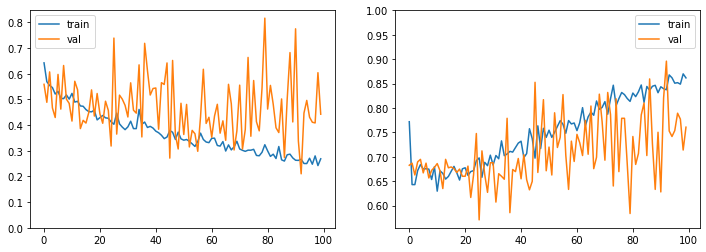

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6659 - accuracy: 0.5946 - precision: 0.9556 - recall: 0.5928 - f1: 0.7172 - specificity: 0.5225 - negative_predictive_value: 0.0923 - matthews_correlation_coefficient: 0.0964 - val_loss: 0.7829 - val_accuracy: 0.4683 - val_precision: 0.9539 - val_recall: 0.4321 - val_f1: 0.5897 - val_specificity: 0.7387 - val_negative_predictive_value: 0.0831 - val_matthews_correlation_coefficient: 0.1212

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.12121, saving model to ../models/autoencoders_requirements/pixelation_2020_03_21-12_55_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6424 - accuracy: 0.6048 - precision: 0.9673 - recall: 0.6042 - f1: 0.7294 - specificity: 0.5419 - negative_predictive_value: 0.0915 - matthews_correlation_coefficient: 0.1116 - val_loss: 0.5441 - val_accuracy: 0.7216 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.20510
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5037 - accuracy: 0.7408 - precision: 0.9801 - recall: 0.7422 - f1: 0.8404 - specificity: 0.6645 - negative_predictive_value: 0.1710 - matthews_correlation_coefficient: 0.2531 - val_loss: 0.3593 - val_accuracy: 0.8066 - val_precision: 0.9660 - val_recall: 0.8285 - val_f1: 0.8902 - val_specificity: 0.4892 - val_negative_predictive_value: 0.1704 - val_matthews_correlation_coefficient: 0.2059

Epoch 00015: val_matthews_correlation_coefficient improved from 0.20510 to 0.20593, saving model to ../models/autoencoders_requirements/pixelation_2020_03_21-12_55_03.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4983 - accuracy: 0.7319 - precision: 0.9780 - recall: 0.7330 - f1: 0.8345 - specificity: 0.6418 - negative_predictive_value: 0.1529 - matthews_correlation_coefficient: 0.2252 - val_loss: 0.3397 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4835 - accuracy: 0.7182 - precision: 0.9834 - recall: 0.7111 - f1: 0.8214 - specificity: 0.6538 - negative_predictive_value: 0.1539 - matthews_correlation_coefficient: 0.2331 - val_loss: 0.3246 - val_accuracy: 0.8170 - val_precision: 0.9533 - val_recall: 0.8518 - val_f1: 0.8985 - val_specificity: 0.2923 - val_negative_predictive_value: 0.1274 - val_matthews_correlation_coefficient: 0.1085

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.23317
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4907 - accuracy: 0.7330 - precision: 0.9828 - recall: 0.7307 - f1: 0.8348 - specificity: 0.6852 - negative_predictive_value: 0.1697 - matthews_correlation_coefficient: 0.2552 - val_loss: 0.3825 - val_accuracy: 0.7745 - val_precision: 0.9699 - val_recall: 0.7904 - val_f1: 0.8694 - val_specificity: 0.5225 - val_negative_predictive_value: 0.1460 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.27286
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4538 - accuracy: 0.7451 - precision: 0.9845 - recall: 0.7426 - f1: 0.8424 - specificity: 0.6721 - negative_predictive_value: 0.1706 - matthews_correlation_coefficient: 0.2584 - val_loss: 0.2508 - val_accuracy: 0.9167 - val_precision: 0.9459 - val_recall: 0.9699 - val_f1: 0.9569 - val_specificity: 0.1023 - val_negative_predictive_value: 0.1847 - val_matthews_correlation_coefficient: 0.0928

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.27286
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4634 - accuracy: 0.7319 - precision: 0.9840 - recall: 0.7267 - f1: 0.8320 - specificity: 0.7120 - negative_predictive_value: 0.1695 - matthews_correlation_coefficient: 0.2624 - val_loss: 0.2763 - val_accuracy: 0.8890 - val_precision: 0.9601 - val_recall: 0.9243 - val_f1: 0.9407 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.28720
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4262 - accuracy: 0.7729 - precision: 0.9848 - recall: 0.7682 - f1: 0.8608 - specificity: 0.7420 - negative_predictive_value: 0.1870 - matthews_correlation_coefficient: 0.2957 - val_loss: 0.3829 - val_accuracy: 0.8161 - val_precision: 0.9638 - val_recall: 0.8414 - val_f1: 0.8972 - val_specificity: 0.4518 - val_negative_predictive_value: 0.1611 - val_matthews_correlation_coefficient: 0.1900

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.28720
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4369 - accuracy: 0.7605 - precision: 0.9842 - recall: 0.7583 - f1: 0.8524 - specificity: 0.7195 - negative_predictive_value: 0.1903 - matthews_correlation_coefficient: 0.2883 - val_loss: 0.5207 - val_accuracy: 0.7311 - val_precision: 0.9497 - val_recall: 0.7116 - val_f1: 0.8120 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.29332
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4311 - accuracy: 0.7553 - precision: 0.9855 - recall: 0.7494 - f1: 0.8481 - specificity: 0.7523 - negative_predictive_value: 0.1796 - matthews_correlation_coefficient: 0.2872 - val_loss: 0.2618 - val_accuracy: 0.9219 - val_precision: 0.9580 - val_recall: 0.9617 - val_f1: 0.9591 - val_specificity: 0.3216 - val_negative_predictive_value: 0.3243 - val_matthews_correlation_coefficient: 0.2734

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.29332
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4227 - accuracy: 0.7803 - precision: 0.9848 - recall: 0.7801 - f1: 0.8678 - specificity: 0.7298 - negative_predictive_value: 0.1913 - matthews_correlation_coefficient: 0.2980 - val_loss: 0.3054 - val_accuracy: 0.8517 - val_precision: 0.9609 - val_recall: 0.8829 - val_f1: 0.9191 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.29332
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4154 - accuracy: 0.7605 - precision: 0.9870 - recall: 0.7538 - f1: 0.8518 - specificity: 0.7036 - negative_predictive_value: 0.1864 - matthews_correlation_coefficient: 0.2878 - val_loss: 0.4069 - val_accuracy: 0.7997 - val_precision: 0.9631 - val_recall: 0.8224 - val_f1: 0.8860 - val_specificity: 0.4640 - val_negative_predictive_value: 0.1474 - val_matthews_correlation_coefficient: 0.1774

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.29332
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4176 - accuracy: 0.7512 - precision: 0.9850 - recall: 0.7453 - f1: 0.8453 - specificity: 0.7001 - negative_predictive_value: 0.1786 - matthews_correlation_coefficient: 0.2749 - val_loss: 0.2890 - val_accuracy: 0.8855 - val_precision: 0.9575 - val_recall: 0.9232 - val_f1: 0.9390 - val_spe

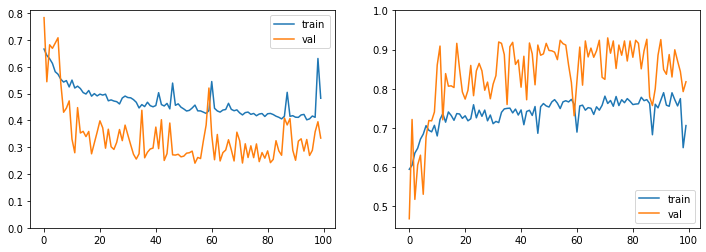

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5418 - accuracy: 0.6859 - precision: 0.9695 - recall: 0.6703 - f1: 0.7832 - specificity: 0.7893 - negative_predictive_value: 0.2205 - matthews_correlation_coefficient: 0.2947 - val_loss: 0.5352 - val_accuracy: 0.6479 - val_precision: 0.9573 - val_recall: 0.5991 - val_f1: 0.7338 - val_specificity: 0.9167 - val_negative_predictive_value: 0.2439 - val_matthews_correlation_coefficient: 0.3161

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31614, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_21-13_09_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4885 - accuracy: 0.6770 - precision: 0.9836 - recall: 0.6519 - f1: 0.7793 - specificity: 0.9036 - negative_predictive_value: 0.2484 - matthews_correlation_coefficient: 0.3515 - val_loss: 0.4602 - val_accuracy: 0.6730 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3845 - accuracy: 0.8217 - precision: 0.9826 - recall: 0.8178 - f1: 0.8889 - specificity: 0.8505 - negative_predictive_value: 0.3798 - matthews_correlation_coefficient: 0.4805 - val_loss: 0.3593 - val_accuracy: 0.8482 - val_precision: 0.9533 - val_recall: 0.8248 - val_f1: 0.8832 - val_specificity: 0.8443 - val_negative_predictive_value: 0.4014 - val_matthews_correlation_coefficient: 0.4786

Epoch 00015: val_matthews_correlation_coefficient improved from 0.46309 to 0.47861, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_21-13_09_50.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.8204 - precision: 0.9741 - recall: 0.8100 - f1: 0.8805 - specificity: 0.8594 - negative_predictive_value: 0.3977 - matthews_correlation_coefficient: 0.4933 - val_loss: 0.4289 - val_accuracy: 0.8040 - val_precision: 0.9561 - val_recall: 0.7722 - val_f1: 0.8530 - val


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.47988
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3498 - accuracy: 0.8436 - precision: 0.9853 - recall: 0.8346 - f1: 0.9010 - specificity: 0.8561 - negative_predictive_value: 0.4084 - matthews_correlation_coefficient: 0.5165 - val_loss: 0.3323 - val_accuracy: 0.8586 - val_precision: 0.9504 - val_recall: 0.8388 - val_f1: 0.8899 - val_specificity: 0.8008 - val_negative_predictive_value: 0.4199 - val_matthews_correlation_coefficient: 0.4798

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.47988
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3412 - accuracy: 0.8490 - precision: 0.9825 - recall: 0.8464 - f1: 0.9071 - specificity: 0.8653 - negative_predictive_value: 0.4220 - matthews_correlation_coefficient: 0.5274 - val_loss: 0.3960 - val_accuracy: 0.8413 - val_precision: 0.9550 - val_recall: 0.8149 - val_f1: 0.8784 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3365 - accuracy: 0.8516 - precision: 0.9814 - recall: 0.8489 - f1: 0.9073 - specificity: 0.8321 - negative_predictive_value: 0.4149 - matthews_correlation_coefficient: 0.5148 - val_loss: 0.4935 - val_accuracy: 0.7840 - val_precision: 0.9557 - val_recall: 0.7507 - val_f1: 0.8398 - val_specificity: 0.8722 - val_negative_predictive_value: 0.3244 - val_matthews_correlation_coefficient: 0.4104

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.48903
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3651 - accuracy: 0.8228 - precision: 0.9858 - recall: 0.8150 - f1: 0.8860 - specificity: 0.8659 - negative_predictive_value: 0.3928 - matthews_correlation_coefficient: 0.4984 - val_loss: 0.3518 - val_accuracy: 0.8560 - val_precision: 0.9461 - val_recall: 0.8394 - val_f1: 0.8887 - val_specificity: 0.7749 - val_negative_predictive_value: 0.4072 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.51063
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3311 - accuracy: 0.8568 - precision: 0.9842 - recall: 0.8512 - f1: 0.9103 - specificity: 0.8646 - negative_predictive_value: 0.4308 - matthews_correlation_coefficient: 0.5360 - val_loss: 0.4137 - val_accuracy: 0.8404 - val_precision: 0.9560 - val_recall: 0.8132 - val_f1: 0.8778 - val_specificity: 0.8655 - val_negative_predictive_value: 0.3910 - val_matthews_correlation_coefficient: 0.4769

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.51063
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3185 - accuracy: 0.8603 - precision: 0.9871 - recall: 0.8555 - f1: 0.9149 - specificity: 0.8886 - negative_predictive_value: 0.4353 - matthews_correlation_coefficient: 0.5526 - val_loss: 0.3411 - val_accuracy: 0.8586 - val_precision: 0.9494 - val_recall: 0.8397 - val_f1: 0.8902 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.51063
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3005 - accuracy: 0.8705 - precision: 0.9872 - recall: 0.8641 - f1: 0.9196 - specificity: 0.8511 - negative_predictive_value: 0.4560 - matthews_correlation_coefficient: 0.5586 - val_loss: 0.4117 - val_accuracy: 0.8569 - val_precision: 0.9533 - val_recall: 0.8339 - val_f1: 0.8884 - val_specificity: 0.8443 - val_negative_predictive_value: 0.4195 - val_matthews_correlation_coefficient: 0.4941

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.51063
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3086 - accuracy: 0.8705 - precision: 0.9867 - recall: 0.8652 - f1: 0.9199 - specificity: 0.8858 - negative_predictive_value: 0.4538 - matthews_correlation_coefficient: 0.5660 - val_loss: 0.3624 - val_accuracy: 0.8508 - val_precision: 0.9531 - val_recall: 0.8270 - val_f1: 0.8846 - val_spe

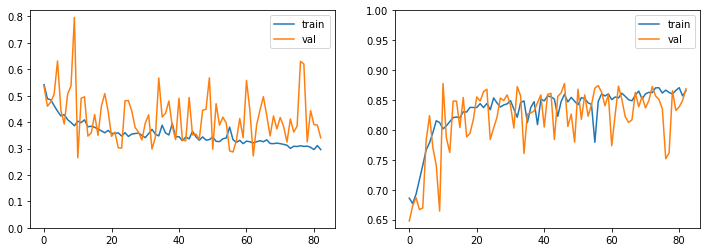

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6329 - accuracy: 0.5312 - precision: 0.9182 - recall: 0.4568 - f1: 0.5967 - specificity: 0.8262 - negative_predictive_value: 0.2827 - matthews_correlation_coefficient: 0.2363 - val_loss: 0.6047 - val_accuracy: 0.5447 - val_precision: 0.8756 - val_recall: 0.4751 - val_f1: 0.6096 - val_specificity: 0.7874 - val_negative_predictive_value: 0.2992 - val_matthews_correlation_coefficient: 0.2123

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21232, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-13_22_09.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6276 - accuracy: 0.5466 - precision: 0.9271 - recall: 0.4720 - f1: 0.6169 - specificity: 0.8420 - negative_predictive_value: 0.2868 - matthews_correlation_coefficient: 0.2568 - val_loss: 0.5803 - val_accuracy: 0.5768 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5862 - accuracy: 0.6174 - precision: 0.9222 - recall: 0.5744 - f1: 0.6944 - specificity: 0.7734 - negative_predictive_value: 0.3202 - matthews_correlation_coefficient: 0.2892 - val_loss: 0.5460 - val_accuracy: 0.6964 - val_precision: 0.8854 - val_recall: 0.6721 - val_f1: 0.7599 - val_specificity: 0.7283 - val_negative_predictive_value: 0.3888 - val_matthews_correlation_coefficient: 0.3291

Epoch 00015: val_matthews_correlation_coefficient improved from 0.28929 to 0.32907, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-13_22_09.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5805 - accuracy: 0.6527 - precision: 0.9177 - recall: 0.6134 - f1: 0.7253 - specificity: 0.7865 - negative_predictive_value: 0.3510 - matthews_correlation_coefficient: 0.3318 - val_loss: 0.7043 - val_accuracy: 0.5412 - val_precision: 0.9073 - val_recall: 0.4461 - val_f1: 0.5915 - val_spec


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.32907
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5597 - accuracy: 0.6822 - precision: 0.9245 - recall: 0.6627 - f1: 0.7630 - specificity: 0.7716 - negative_predictive_value: 0.3726 - matthews_correlation_coefficient: 0.3547 - val_loss: 0.4886 - val_accuracy: 0.7641 - val_precision: 0.8595 - val_recall: 0.7919 - val_f1: 0.8208 - val_specificity: 0.5789 - val_negative_predictive_value: 0.4739 - val_matthews_correlation_coefficient: 0.3460

Epoch 00030: val_matthews_correlation_coefficient improved from 0.32907 to 0.34596, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-13_22_09.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5521 - accuracy: 0.6844 - precision: 0.9239 - recall: 0.6660 - f1: 0.7678 - specificity: 0.7776 - negative_predictive_value: 0.3766 - matthews_correlation_coefficient: 0.3616 - val_loss: 0.6287 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5278 - accuracy: 0.6978 - precision: 0.9191 - recall: 0.6732 - f1: 0.7700 - specificity: 0.7763 - negative_predictive_value: 0.3887 - matthews_correlation_coefficient: 0.3760 - val_loss: 0.4720 - val_accuracy: 0.7433 - val_precision: 0.8649 - val_recall: 0.7554 - val_f1: 0.8033 - val_specificity: 0.6234 - val_negative_predictive_value: 0.4293 - val_matthews_correlation_coefficient: 0.3316

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.35341
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5343 - accuracy: 0.6993 - precision: 0.9213 - recall: 0.6743 - f1: 0.7720 - specificity: 0.7794 - negative_predictive_value: 0.3874 - matthews_correlation_coefficient: 0.3698 - val_loss: 0.5923 - val_accuracy: 0.6678 - val_precision: 0.8949 - val_recall: 0.6247 - val_f1: 0.7319 - val_specificity: 0.7837 - val_negative_predictive_value: 0.3725 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36364
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5111 - accuracy: 0.7208 - precision: 0.9286 - recall: 0.7075 - f1: 0.7971 - specificity: 0.7772 - negative_predictive_value: 0.4062 - matthews_correlation_coefficient: 0.3995 - val_loss: 0.4604 - val_accuracy: 0.7684 - val_precision: 0.8701 - val_recall: 0.7850 - val_f1: 0.8224 - val_specificity: 0.6321 - val_negative_predictive_value: 0.4674 - val_matthews_correlation_coefficient: 0.3717

Epoch 00059: val_matthews_correlation_coefficient improved from 0.36364 to 0.37170, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-13_22_09.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5248 - accuracy: 0.7202 - precision: 0.9242 - recall: 0.7089 - f1: 0.7954 - specificity: 0.7593 - negative_predictive_value: 0.4004 - matthews_correlation_coefficient: 0.3862 - val_loss: 0.8195 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4965 - accuracy: 0.7310 - precision: 0.9332 - recall: 0.7130 - f1: 0.8025 - specificity: 0.7921 - negative_predictive_value: 0.4193 - matthews_correlation_coefficient: 0.4201 - val_loss: 0.5455 - val_accuracy: 0.7086 - val_precision: 0.9000 - val_recall: 0.6778 - val_f1: 0.7683 - val_specificity: 0.7825 - val_negative_predictive_value: 0.4116 - val_matthews_correlation_coefficient: 0.3755

Epoch 00073: val_matthews_correlation_coefficient improved from 0.37528 to 0.37550, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_21-13_22_09.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5098 - accuracy: 0.7202 - precision: 0.9274 - recall: 0.7055 - f1: 0.7946 - specificity: 0.7742 - negative_predictive_value: 0.4060 - matthews_correlation_coefficient: 0.3968 - val_loss: 0.5018 - val_accuracy: 0.7225 - val_precision: 0.8887 - val_recall: 0.7044 - val_f1: 0.7821 - val_spec


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.38350
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4920 - accuracy: 0.7341 - precision: 0.9269 - recall: 0.7233 - f1: 0.8061 - specificity: 0.7816 - negative_predictive_value: 0.4180 - matthews_correlation_coefficient: 0.4155 - val_loss: 0.5533 - val_accuracy: 0.6964 - val_precision: 0.9076 - val_recall: 0.6496 - val_f1: 0.7538 - val_specificity: 0.8101 - val_negative_predictive_value: 0.3934 - val_matthews_correlation_coefficient: 0.3697

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.38350
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4998 - accuracy: 0.7315 - precision: 0.9231 - recall: 0.7150 - f1: 0.7991 - specificity: 0.7690 - negative_predictive_value: 0.4224 - matthews_correlation_coefficient: 0.4122 - val_loss: 0.7153 - val_accuracy: 0.6305 - val_precision: 0.9117 - val_recall: 0.5624 - val_f1: 0.6909 - val_spe

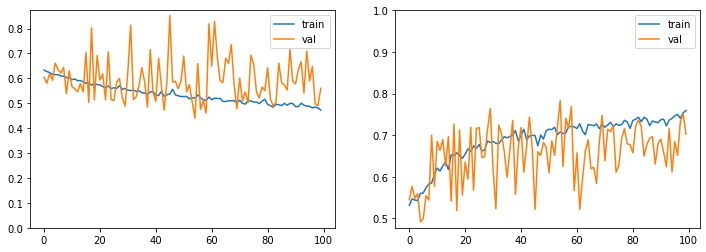

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5068 - accuracy: 0.7573 - precision: 0.8295 - recall: 0.7818 - f1: 0.7928 - specificity: 0.7239 - negative_predictive_value: 0.6737 - matthews_correlation_coefficient: 0.5021 - val_loss: 0.5769 - val_accuracy: 0.6557 - val_precision: 0.8997 - val_recall: 0.5023 - val_f1: 0.6395 - val_specificity: 0.8919 - val_negative_predictive_value: 0.4919 - val_matthews_correlation_coefficient: 0.4182

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.41819, saving model to ../models/autoencoders_requirements/varied_background_2020_03_21-13_36_53.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4544 - accuracy: 0.7898 - precision: 0.8583 - recall: 0.8201 - f1: 0.8293 - specificity: 0.7420 - negative_predictive_value: 0.7055 - matthews_correlation_coefficient: 0.5615 - val_loss: 0.4235 - val_accuracy: 0.8153 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3829 - accuracy: 0.8275 - precision: 0.8828 - recall: 0.8575 - f1: 0.8632 - specificity: 0.7836 - negative_predictive_value: 0.7558 - matthews_correlation_coefficient: 0.6384 - val_loss: 0.3542 - val_accuracy: 0.8569 - val_precision: 0.8686 - val_recall: 0.9294 - val_f1: 0.8956 - val_specificity: 0.7095 - val_negative_predictive_value: 0.8106 - val_matthews_correlation_coefficient: 0.6573

Epoch 00014: val_matthews_correlation_coefficient improved from 0.65112 to 0.65733, saving model to ../models/autoencoders_requirements/varied_background_2020_03_21-13_36_53.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3804 - accuracy: 0.8297 - precision: 0.8726 - recall: 0.8558 - f1: 0.8575 - specificity: 0.7761 - negative_predictive_value: 0.7629 - matthews_correlation_coefficient: 0.6319 - val_loss: 0.3691 - val_accuracy: 0.8534 - val_precision: 0.8878 - val_recall: 0.8983 - val_f1: 0.8899 - va


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.68736
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3628 - accuracy: 0.8401 - precision: 0.8949 - recall: 0.8594 - f1: 0.8710 - specificity: 0.8110 - negative_predictive_value: 0.7608 - matthews_correlation_coefficient: 0.6615 - val_loss: 0.3472 - val_accuracy: 0.8491 - val_precision: 0.8384 - val_recall: 0.9642 - val_f1: 0.8942 - val_specificity: 0.6250 - val_negative_predictive_value: 0.8604 - val_matthews_correlation_coefficient: 0.6391

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.68736
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3436 - accuracy: 0.8549 - precision: 0.9007 - recall: 0.8760 - f1: 0.8837 - specificity: 0.8163 - negative_predictive_value: 0.7836 - matthews_correlation_coefficient: 0.6886 - val_loss: 0.3419 - val_accuracy: 0.8647 - val_precision: 0.8492 - val_recall: 0.9060 - val_f1: 0.8744 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3332 - accuracy: 0.8610 - precision: 0.9035 - recall: 0.8785 - f1: 0.8866 - specificity: 0.8216 - negative_predictive_value: 0.7951 - matthews_correlation_coefficient: 0.7001 - val_loss: 0.3558 - val_accuracy: 0.8586 - val_precision: 0.8351 - val_recall: 0.9153 - val_f1: 0.8707 - val_specificity: 0.6973 - val_negative_predictive_value: 0.8402 - val_matthews_correlation_coefficient: 0.6684

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.69752
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3314 - accuracy: 0.8638 - precision: 0.9106 - recall: 0.8782 - f1: 0.8903 - specificity: 0.8383 - negative_predictive_value: 0.7855 - matthews_correlation_coefficient: 0.7067 - val_loss: 0.3434 - val_accuracy: 0.8638 - val_precision: 0.8680 - val_recall: 0.9421 - val_f1: 0.9009 - val_specificity: 0.7034 - val_negative_predictive_value: 0.8385 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3380 - accuracy: 0.8536 - precision: 0.8964 - recall: 0.8680 - f1: 0.8760 - specificity: 0.8371 - negative_predictive_value: 0.7887 - matthews_correlation_coefficient: 0.6952 - val_loss: 0.3598 - val_accuracy: 0.8647 - val_precision: 0.8932 - val_recall: 0.9059 - val_f1: 0.8965 - val_specificity: 0.7712 - val_negative_predictive_value: 0.7959 - val_matthews_correlation_coefficient: 0.6819

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.69752
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3220 - accuracy: 0.8698 - precision: 0.9094 - recall: 0.8911 - f1: 0.8968 - specificity: 0.8325 - negative_predictive_value: 0.8057 - matthews_correlation_coefficient: 0.7180 - val_loss: 0.3355 - val_accuracy: 0.8647 - val_precision: 0.8658 - val_recall: 0.9476 - val_f1: 0.9024 - val_specificity: 0.6967 - val_negative_predictive_value: 0.8422 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.70491
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3082 - accuracy: 0.8727 - precision: 0.9145 - recall: 0.8909 - f1: 0.8992 - specificity: 0.8433 - negative_predictive_value: 0.8033 - matthews_correlation_coefficient: 0.7248 - val_loss: 0.3952 - val_accuracy: 0.8369 - val_precision: 0.8160 - val_recall: 0.9072 - val_f1: 0.8567 - val_specificity: 0.6493 - val_negative_predictive_value: 0.8114 - val_matthews_correlation_coefficient: 0.6162

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.70491
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3075 - accuracy: 0.8714 - precision: 0.9163 - recall: 0.8875 - f1: 0.8977 - specificity: 0.8521 - negative_predictive_value: 0.8075 - matthews_correlation_coefficient: 0.7306 - val_loss: 0.3494 - val_accuracy: 0.8621 - val_precision: 0.8618 - val_recall: 0.9466 - val_f1: 0.9001 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.71034
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3074 - accuracy: 0.8725 - precision: 0.9134 - recall: 0.8782 - f1: 0.8908 - specificity: 0.8578 - negative_predictive_value: 0.7997 - matthews_correlation_coefficient: 0.7231 - val_loss: 0.3510 - val_accuracy: 0.8682 - val_precision: 0.9036 - val_recall: 0.9006 - val_f1: 0.8997 - val_specificity: 0.7935 - val_negative_predictive_value: 0.7855 - val_matthews_correlation_coefficient: 0.6906

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.71034
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3098 - accuracy: 0.8748 - precision: 0.9208 - recall: 0.8874 - f1: 0.8992 - specificity: 0.8585 - negative_predictive_value: 0.8041 - matthews_correlation_coefficient: 0.7340 - val_loss: 0.3139 - val_accuracy: 0.8829 - val_precision: 0.8864 - val_recall: 0.9482 - val_f1: 0.9141 - val_spe

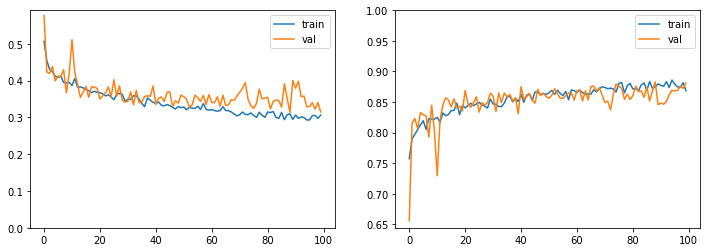

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6064 - accuracy: 0.6733 - precision: 0.9144 - recall: 0.6530 - f1: 0.7568 - specificity: 0.7585 - negative_predictive_value: 0.3552 - matthews_correlation_coefficient: 0.3305 - val_loss: 0.5938 - val_accuracy: 0.6730 - val_precision: 0.9141 - val_recall: 0.6119 - val_f1: 0.7292 - val_specificity: 0.8410 - val_negative_predictive_value: 0.3739 - val_matthews_correlation_coefficient: 0.3586

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35856, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_21-13_51_38.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5918 - accuracy: 0.6779 - precision: 0.9238 - recall: 0.6554 - f1: 0.7625 - specificity: 0.7723 - negative_predictive_value: 0.3576 - matthews_correlation_coefficient: 0.3433 - val_loss: 0.5996 - val_accuracy: 0.6756 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5763 - accuracy: 0.6839 - precision: 0.9262 - recall: 0.6566 - f1: 0.7647 - specificity: 0.7894 - negative_predictive_value: 0.3625 - matthews_correlation_coefficient: 0.3566 - val_loss: 0.5781 - val_accuracy: 0.6748 - val_precision: 0.9131 - val_recall: 0.6149 - val_f1: 0.7310 - val_specificity: 0.8316 - val_negative_predictive_value: 0.3742 - val_matthews_correlation_coefficient: 0.3558

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36820
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5758 - accuracy: 0.6842 - precision: 0.9247 - recall: 0.6600 - f1: 0.7661 - specificity: 0.7735 - negative_predictive_value: 0.3611 - matthews_correlation_coefficient: 0.3504 - val_loss: 0.5689 - val_accuracy: 0.6834 - val_precision: 0.9147 - val_recall: 0.6256 - val_f1: 0.7388 - val_specificity: 0.8296 - val_negative_predictive_value: 0.3811 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5688 - accuracy: 0.6898 - precision: 0.9297 - recall: 0.6604 - f1: 0.7686 - specificity: 0.8063 - negative_predictive_value: 0.3708 - matthews_correlation_coefficient: 0.3721 - val_loss: 0.6040 - val_accuracy: 0.6800 - val_precision: 0.9133 - val_recall: 0.6233 - val_f1: 0.7373 - val_specificity: 0.8323 - val_negative_predictive_value: 0.3779 - val_matthews_correlation_coefficient: 0.3616

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.36820
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5686 - accuracy: 0.6896 - precision: 0.9211 - recall: 0.6684 - f1: 0.7701 - specificity: 0.7859 - negative_predictive_value: 0.3712 - matthews_correlation_coefficient: 0.3638 - val_loss: 0.6334 - val_accuracy: 0.6687 - val_precision: 0.9165 - val_recall: 0.6060 - val_f1: 0.7257 - val_specificity: 0.8424 - val_negative_predictive_value: 0.3700 - val_matthews_correlation_coefficie


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36820
Epoch 00044: early stopping

   Final Accuracy:  68.00%
  Final Precision:  94.39%
     Final Recall:  63.81%
  Final F-measure:  76.15%
Final Specificity:  84.78%
        Final NPV:  36.86%
        Final MCC:  38.97%
[[195  35]
 [334 589]]
              precision    recall  f1-score   support

           0       0.37      0.85      0.51       230
           1       0.94      0.64      0.76       923

    accuracy                           0.68      1153
   macro avg       0.66      0.74      0.64      1153
weighted avg       0.83      0.68      0.71      1153



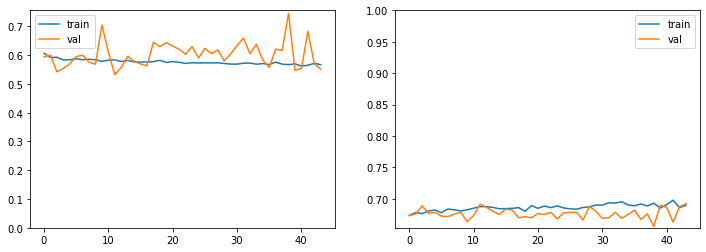

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6337 - accuracy: 0.6518 - precision: 0.6828 - recall: 0.6252 - f1: 0.6226 - specificity: 0.6755 - negative_predictive_value: 0.6498 - matthews_correlation_coefficient: 0.3222 - val_loss: 0.6172 - val_accuracy: 0.6002 - val_precision: 0.7254 - val_recall: 0.3526 - val_f1: 0.4656 - val_specificity: 0.8459 - val_negative_predictive_value: 0.5336 - val_matthews_correlation_coefficient: 0.2526

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25257, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_21-13_58_16.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5904 - accuracy: 0.6870 - precision: 0.7024 - recall: 0.7217 - f1: 0.6970 - specificity: 0.6460 - negative_predictive_value: 0.6854 - matthews_correlation_coefficient: 0.3788 - val_loss: 0.5604 - val_accuracy: 0.7077 - 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.47644
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4780 - accuracy: 0.7573 - precision: 0.7604 - recall: 0.7745 - f1: 0.7618 - specificity: 0.7312 - negative_predictive_value: 0.7550 - matthews_correlation_coefficient: 0.5121 - val_loss: 0.5062 - val_accuracy: 0.7450 - val_precision: 0.7771 - val_recall: 0.7390 - val_f1: 0.7529 - val_specificity: 0.7378 - val_negative_predictive_value: 0.6950 - val_matthews_correlation_coefficient: 0.4742

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.47644
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4852 - accuracy: 0.7512 - precision: 0.7755 - recall: 0.7390 - f1: 0.7450 - specificity: 0.7552 - negative_predictive_value: 0.7315 - matthews_correlation_coefficient: 0.5068 - val_loss: 0.5300 - val_accuracy: 0.7320 - val_precision: 0.6926 - val_recall: 0.9163 - val_f1: 0.7842 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4557 - accuracy: 0.7633 - precision: 0.7706 - recall: 0.7825 - f1: 0.7680 - specificity: 0.7437 - negative_predictive_value: 0.7581 - matthews_correlation_coefficient: 0.5287 - val_loss: 0.5424 - val_accuracy: 0.7190 - val_precision: 0.7498 - val_recall: 0.6538 - val_f1: 0.6925 - val_specificity: 0.7471 - val_negative_predictive_value: 0.6542 - val_matthews_correlation_coefficient: 0.4292

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.50912
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4560 - accuracy: 0.7616 - precision: 0.7738 - recall: 0.7616 - f1: 0.7605 - specificity: 0.7575 - negative_predictive_value: 0.7456 - matthews_correlation_coefficient: 0.5206 - val_loss: 0.4756 - val_accuracy: 0.7528 - val_precision: 0.7175 - val_recall: 0.9005 - val_f1: 0.7942 - val_specificity: 0.5694 - val_negative_predictive_value: 0.8169 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.53270
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4380 - accuracy: 0.7738 - precision: 0.7955 - recall: 0.7791 - f1: 0.7782 - specificity: 0.7725 - negative_predictive_value: 0.7519 - matthews_correlation_coefficient: 0.5510 - val_loss: 0.4683 - val_accuracy: 0.7745 - val_precision: 0.7371 - val_recall: 0.8216 - val_f1: 0.7726 - val_specificity: 0.6752 - val_negative_predictive_value: 0.7751 - val_matthews_correlation_coefficient: 0.5309

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.53270
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4387 - accuracy: 0.7766 - precision: 0.8037 - recall: 0.7709 - f1: 0.7790 - specificity: 0.7802 - negative_predictive_value: 0.7515 - matthews_correlation_coefficient: 0.5546 - val_loss: 0.4649 - val_accuracy: 0.7650 - val_precision: 0.7619 - val_recall: 0.8219 - val_f1: 0.7863 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4205 - accuracy: 0.7902 - precision: 0.8136 - recall: 0.7887 - f1: 0.7944 - specificity: 0.7902 - negative_predictive_value: 0.7659 - matthews_correlation_coefficient: 0.5789 - val_loss: 0.4478 - val_accuracy: 0.7702 - val_precision: 0.7362 - val_recall: 0.8176 - val_f1: 0.7696 - val_specificity: 0.6709 - val_negative_predictive_value: 0.7711 - val_matthews_correlation_coefficient: 0.5239

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.56042
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4359 - accuracy: 0.7753 - precision: 0.8068 - recall: 0.7722 - f1: 0.7784 - specificity: 0.7891 - negative_predictive_value: 0.7628 - matthews_correlation_coefficient: 0.5652 - val_loss: 0.4514 - val_accuracy: 0.7650 - val_precision: 0.7390 - val_recall: 0.7952 - val_f1: 0.7606 - val_specificity: 0.6857 - val_negative_predictive_value: 0.7552 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.57042
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4363 - accuracy: 0.7926 - precision: 0.7993 - recall: 0.8039 - f1: 0.7956 - specificity: 0.7690 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.5831 - val_loss: 0.4576 - val_accuracy: 0.7806 - val_precision: 0.8081 - val_recall: 0.7827 - val_f1: 0.7896 - val_specificity: 0.7650 - val_negative_predictive_value: 0.7356 - val_matthews_correlation_coefficient: 0.5455

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.57042
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4215 - accuracy: 0.7920 - precision: 0.8089 - recall: 0.7879 - f1: 0.7910 - specificity: 0.7960 - negative_predictive_value: 0.7726 - matthews_correlation_coefficient: 0.5841 - val_loss: 0.4501 - val_accuracy: 0.7788 - val_precision: 0.7659 - val_recall: 0.8575 - val_f1: 0.8043 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4127 - accuracy: 0.7978 - precision: 0.8134 - recall: 0.7929 - f1: 0.7965 - specificity: 0.7996 - negative_predictive_value: 0.7781 - matthews_correlation_coefficient: 0.5934 - val_loss: 0.4767 - val_accuracy: 0.7702 - val_precision: 0.7181 - val_recall: 0.8561 - val_f1: 0.7762 - val_specificity: 0.6293 - val_negative_predictive_value: 0.8069 - val_matthews_correlation_coefficient: 0.5303

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.57275
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4067 - accuracy: 0.7970 - precision: 0.8137 - recall: 0.8057 - f1: 0.8007 - specificity: 0.7926 - negative_predictive_value: 0.7770 - matthews_correlation_coefficient: 0.5957 - val_loss: 0.4720 - val_accuracy: 0.7719 - val_precision: 0.7648 - val_recall: 0.8368 - val_f1: 0.7944 - val_specificity: 0.6855 - val_negative_predictive_value: 0.7679 - val_matthews_correlation_coefficie

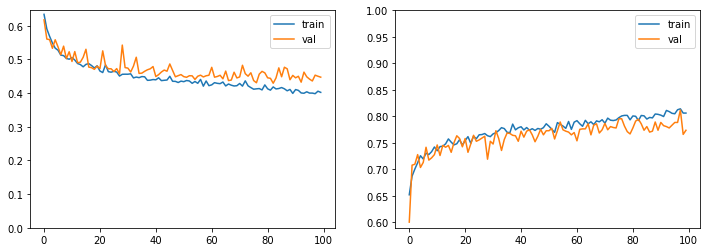

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6417 - accuracy: 0.5499 - precision: 0.9009 - recall: 0.4820 - f1: 0.6168 - specificity: 0.7890 - negative_predictive_value: 0.2987 - matthews_correlation_coefficient: 0.2315 - val_loss: 0.6355 - val_accuracy: 0.5690 - val_precision: 0.8959 - val_recall: 0.5198 - val_f1: 0.6492 - val_specificity: 0.7570 - val_negative_predictive_value: 0.3020 - val_matthews_correlation_coefficient: 0.2327

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23267, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_21-14_13_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6253 - accuracy: 0.5694 - precision: 0.8923 - recall: 0.5024 - f1: 0.6337 - specificity: 0.7808 - negative_predictive_value: 0.3099 - matthews_correlation_coefficient: 0.2450 - val_loss: 0.6589 - val_accuracy: 0.5282 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.31020
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5783 - accuracy: 0.6328 - precision: 0.9126 - recall: 0.5892 - f1: 0.7073 - specificity: 0.7839 - negative_predictive_value: 0.3545 - matthews_correlation_coefficient: 0.3143 - val_loss: 0.5711 - val_accuracy: 0.6375 - val_precision: 0.9097 - val_recall: 0.6070 - val_f1: 0.7224 - val_specificity: 0.7543 - val_negative_predictive_value: 0.3427 - val_matthews_correlation_coefficient: 0.3007

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.31020
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5717 - accuracy: 0.6490 - precision: 0.9087 - recall: 0.6187 - f1: 0.7247 - specificity: 0.7748 - negative_predictive_value: 0.3710 - matthews_correlation_coefficient: 0.3282 - val_loss: 0.5383 - val_accuracy: 0.6722 - val_precision: 0.8967 - val_recall: 0.6684 - val_f1: 0.7616 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5537 - accuracy: 0.6879 - precision: 0.9100 - recall: 0.6681 - f1: 0.7599 - specificity: 0.7383 - negative_predictive_value: 0.4062 - matthews_correlation_coefficient: 0.3576 - val_loss: 0.5747 - val_accuracy: 0.6713 - val_precision: 0.8989 - val_recall: 0.6622 - val_f1: 0.7586 - val_specificity: 0.7062 - val_negative_predictive_value: 0.3630 - val_matthews_correlation_coefficient: 0.3095

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.35601
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5436 - accuracy: 0.6961 - precision: 0.9092 - recall: 0.6713 - f1: 0.7645 - specificity: 0.7725 - negative_predictive_value: 0.4152 - matthews_correlation_coefficient: 0.3760 - val_loss: 0.5575 - val_accuracy: 0.6826 - val_precision: 0.9174 - val_recall: 0.6638 - val_f1: 0.7660 - val_specificity: 0.7474 - val_negative_predictive_value: 0.3766 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5313 - accuracy: 0.7111 - precision: 0.9159 - recall: 0.6974 - f1: 0.7841 - specificity: 0.7621 - negative_predictive_value: 0.4303 - matthews_correlation_coefficient: 0.3975 - val_loss: 0.5239 - val_accuracy: 0.7016 - val_precision: 0.9085 - val_recall: 0.6981 - val_f1: 0.7857 - val_specificity: 0.7165 - val_negative_predictive_value: 0.3929 - val_matthews_correlation_coefficient: 0.3523

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38395
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5331 - accuracy: 0.6963 - precision: 0.9127 - recall: 0.6800 - f1: 0.7701 - specificity: 0.7678 - negative_predictive_value: 0.4185 - matthews_correlation_coefficient: 0.3818 - val_loss: 0.5935 - val_accuracy: 0.6409 - val_precision: 0.9168 - val_recall: 0.6071 - val_f1: 0.7250 - val_specificity: 0.7612 - val_negative_predictive_value: 0.3449 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.38590
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5284 - accuracy: 0.7106 - precision: 0.9129 - recall: 0.6993 - f1: 0.7833 - specificity: 0.7369 - negative_predictive_value: 0.4189 - matthews_correlation_coefficient: 0.3784 - val_loss: 0.5786 - val_accuracy: 0.6583 - val_precision: 0.9147 - val_recall: 0.6291 - val_f1: 0.7401 - val_specificity: 0.7614 - val_negative_predictive_value: 0.3605 - val_matthews_correlation_coefficient: 0.3266

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.38590
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5212 - accuracy: 0.7137 - precision: 0.9168 - recall: 0.7011 - f1: 0.7877 - specificity: 0.7717 - negative_predictive_value: 0.4321 - matthews_correlation_coefficient: 0.4030 - val_loss: 0.5068 - val_accuracy: 0.7294 - val_precision: 0.9041 - val_recall: 0.7395 - val_f1: 0.8105 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.40549
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5033 - accuracy: 0.7321 - precision: 0.9192 - recall: 0.7214 - f1: 0.8024 - specificity: 0.7753 - negative_predictive_value: 0.4449 - matthews_correlation_coefficient: 0.4232 - val_loss: 0.5761 - val_accuracy: 0.6592 - val_precision: 0.9283 - val_recall: 0.6227 - val_f1: 0.7397 - val_specificity: 0.7936 - val_negative_predictive_value: 0.3647 - val_matthews_correlation_coefficient: 0.3478

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40549
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5127 - accuracy: 0.7187 - precision: 0.9178 - recall: 0.7042 - f1: 0.7907 - specificity: 0.7665 - negative_predictive_value: 0.4294 - matthews_correlation_coefficient: 0.4030 - val_loss: 0.4975 - val_accuracy: 0.7294 - val_precision: 0.9138 - val_recall: 0.7293 - val_f1: 0.8077 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5064 - accuracy: 0.7282 - precision: 0.9091 - recall: 0.7155 - f1: 0.7950 - specificity: 0.7520 - negative_predictive_value: 0.4356 - matthews_correlation_coefficient: 0.4056 - val_loss: 0.5204 - val_accuracy: 0.7320 - val_precision: 0.9091 - val_recall: 0.7377 - val_f1: 0.8115 - val_specificity: 0.7071 - val_negative_predictive_value: 0.4212 - val_matthews_correlation_coefficient: 0.3822

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.40897
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4939 - accuracy: 0.7425 - precision: 0.9166 - recall: 0.7294 - f1: 0.8064 - specificity: 0.7725 - negative_predictive_value: 0.4615 - matthews_correlation_coefficient: 0.4391 - val_loss: 0.5959 - val_accuracy: 0.6661 - val_precision: 0.9227 - val_recall: 0.6340 - val_f1: 0.7470 - val_specificity: 0.7845 - val_negative_predictive_value: 0.3684 - val_matthews_correlation_coefficie

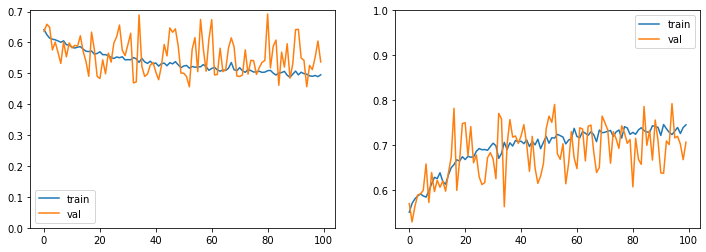

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4754 - accuracy: 0.7512 - precision: 0.8747 - recall: 0.7351 - f1: 0.7909 - specificity: 0.7876 - negative_predictive_value: 0.6028 - matthews_correlation_coefficient: 0.4999 - val_loss: 0.4819 - val_accuracy: 0.7311 - val_precision: 0.8732 - val_recall: 0.6574 - val_f1: 0.7461 - val_specificity: 0.8567 - val_negative_predictive_value: 0.5720 - val_matthews_correlation_coefficient: 0.4770

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.47698, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_21-14_27_57.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4348 - accuracy: 0.7785 - precision: 0.8926 - recall: 0.7664 - f1: 0.8204 - specificity: 0.8186 - negative_predictive_value: 0.6306 - matthews_correlation_coefficient: 0.5518 - val_loss: 0.4655 - val_accuracy: 0.7441 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3954 - accuracy: 0.8069 - precision: 0.9037 - recall: 0.8014 - f1: 0.8439 - specificity: 0.8200 - negative_predictive_value: 0.6627 - matthews_correlation_coefficient: 0.5940 - val_loss: 0.3971 - val_accuracy: 0.8040 - val_precision: 0.8626 - val_recall: 0.7916 - val_f1: 0.8223 - val_specificity: 0.7777 - val_negative_predictive_value: 0.6545 - val_matthews_correlation_coefficient: 0.5683

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.57522
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3873 - accuracy: 0.8137 - precision: 0.9043 - recall: 0.8116 - f1: 0.8500 - specificity: 0.8265 - negative_predictive_value: 0.6768 - matthews_correlation_coefficient: 0.6088 - val_loss: 0.3867 - val_accuracy: 0.8222 - val_precision: 0.8678 - val_recall: 0.8120 - val_f1: 0.8372 - val_specificity: 0.7809 - val_negative_predictive_value: 0.6785 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3611 - accuracy: 0.8354 - precision: 0.9098 - recall: 0.8422 - f1: 0.8713 - specificity: 0.8196 - negative_predictive_value: 0.7114 - matthews_correlation_coefficient: 0.6402 - val_loss: 0.3617 - val_accuracy: 0.8317 - val_precision: 0.8210 - val_recall: 0.8924 - val_f1: 0.8536 - val_specificity: 0.6353 - val_negative_predictive_value: 0.7639 - val_matthews_correlation_coefficient: 0.5816

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.61329
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3626 - accuracy: 0.8356 - precision: 0.9082 - recall: 0.8453 - f1: 0.8714 - specificity: 0.8274 - negative_predictive_value: 0.7228 - matthews_correlation_coefficient: 0.6501 - val_loss: 0.3958 - val_accuracy: 0.8170 - val_precision: 0.8868 - val_recall: 0.7813 - val_f1: 0.8293 - val_specificity: 0.8241 - val_negative_predictive_value: 0.6509 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3382 - accuracy: 0.8521 - precision: 0.9040 - recall: 0.8596 - f1: 0.8786 - specificity: 0.8245 - negative_predictive_value: 0.7423 - matthews_correlation_coefficient: 0.6705 - val_loss: 0.3883 - val_accuracy: 0.8161 - val_precision: 0.8909 - val_recall: 0.7783 - val_f1: 0.8287 - val_specificity: 0.8295 - val_negative_predictive_value: 0.6500 - val_matthews_correlation_coefficient: 0.5993

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.64552
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3586 - accuracy: 0.8358 - precision: 0.9156 - recall: 0.8363 - f1: 0.8671 - specificity: 0.8408 - negative_predictive_value: 0.7325 - matthews_correlation_coefficient: 0.6609 - val_loss: 0.3510 - val_accuracy: 0.8378 - val_precision: 0.8605 - val_recall: 0.8482 - val_f1: 0.8528 - val_specificity: 0.7452 - val_negative_predictive_value: 0.7148 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3352 - accuracy: 0.8419 - precision: 0.9232 - recall: 0.8390 - f1: 0.8749 - specificity: 0.8511 - negative_predictive_value: 0.7203 - matthews_correlation_coefficient: 0.6646 - val_loss: 0.3715 - val_accuracy: 0.8239 - val_precision: 0.8794 - val_recall: 0.8037 - val_f1: 0.8381 - val_specificity: 0.7999 - val_negative_predictive_value: 0.6706 - val_matthews_correlation_coefficient: 0.6023

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.64552
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3319 - accuracy: 0.8482 - precision: 0.9159 - recall: 0.8542 - f1: 0.8812 - specificity: 0.8371 - negative_predictive_value: 0.7310 - matthews_correlation_coefficient: 0.6676 - val_loss: 0.3643 - val_accuracy: 0.8326 - val_precision: 0.8791 - val_recall: 0.8154 - val_f1: 0.8441 - val_specificity: 0.7953 - val_negative_predictive_value: 0.6887 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.65264
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3266 - accuracy: 0.8536 - precision: 0.9230 - recall: 0.8576 - f1: 0.8858 - specificity: 0.8533 - negative_predictive_value: 0.7482 - matthews_correlation_coefficient: 0.6894 - val_loss: 0.3922 - val_accuracy: 0.8222 - val_precision: 0.9028 - val_recall: 0.7753 - val_f1: 0.8309 - val_specificity: 0.8526 - val_negative_predictive_value: 0.6606 - val_matthews_correlation_coefficient: 0.6209

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.65264
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3125 - accuracy: 0.8616 - precision: 0.9167 - recall: 0.8621 - f1: 0.8859 - specificity: 0.8532 - negative_predictive_value: 0.7586 - matthews_correlation_coefficient: 0.6937 - val_loss: 0.3616 - val_accuracy: 0.8439 - val_precision: 0.8825 - val_recall: 0.8317 - val_f1: 0.8539 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.66540
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3036 - accuracy: 0.8662 - precision: 0.9306 - recall: 0.8674 - f1: 0.8953 - specificity: 0.8621 - negative_predictive_value: 0.7542 - matthews_correlation_coefficient: 0.7057 - val_loss: 0.3483 - val_accuracy: 0.8500 - val_precision: 0.8712 - val_recall: 0.8562 - val_f1: 0.8616 - val_specificity: 0.7658 - val_negative_predictive_value: 0.7341 - val_matthews_correlation_coefficient: 0.6395

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.66540
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3064 - accuracy: 0.8640 - precision: 0.9253 - recall: 0.8715 - f1: 0.8947 - specificity: 0.8537 - negative_predictive_value: 0.7553 - matthews_correlation_coefficient: 0.7011 - val_loss: 0.3303 - val_accuracy: 0.8595 - val_precision: 0.8727 - val_recall: 0.8694 - val_f1: 0.8692 - val_spe

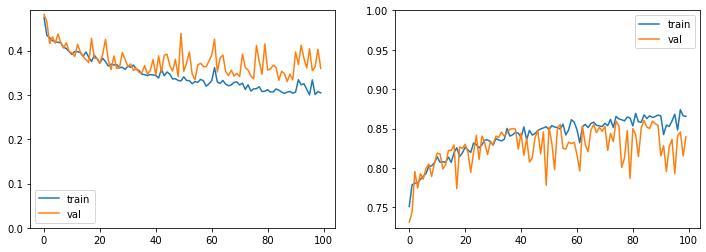

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6501 - accuracy: 0.5525 - precision: 0.8999 - recall: 0.5224 - f1: 0.6280 - specificity: 0.6986 - negative_predictive_value: 0.2243 - matthews_correlation_coefficient: 0.1679 - val_loss: 0.5265 - val_accuracy: 0.7624 - val_precision: 0.8814 - val_recall: 0.7782 - val_f1: 0.8246 - val_specificity: 0.5562 - val_negative_predictive_value: 0.3452 - val_matthews_correlation_coefficient: 0.2998

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29979, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-14_42_47.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6170 - accuracy: 0.6373 - precision: 0.9059 - recall: 0.6256 - f1: 0.7252 - specificity: 0.6786 - negative_predictive_value: 0.2878 - matthews_correlation_coefficient: 0.2370 - val_loss: 0.6482 - val_accuracy: 0.5768 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5328 - accuracy: 0.7215 - precision: 0.9334 - recall: 0.7173 - f1: 0.8046 - specificity: 0.7391 - negative_predictive_value: 0.3415 - matthews_correlation_coefficient: 0.3488 - val_loss: 0.5035 - val_accuracy: 0.7676 - val_precision: 0.9247 - val_recall: 0.7416 - val_f1: 0.8205 - val_specificity: 0.7896 - val_negative_predictive_value: 0.4058 - val_matthews_correlation_coefficient: 0.4150

Epoch 00015: val_matthews_correlation_coefficient improved from 0.38873 to 0.41498, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-14_42_47.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5322 - accuracy: 0.7210 - precision: 0.9377 - recall: 0.7155 - f1: 0.8045 - specificity: 0.7384 - negative_predictive_value: 0.3458 - matthews_correlation_coefficient: 0.3542 - val_loss: 0.4567 - val_accuracy: 0.7780 - val_precision: 0.9043 - val_recall: 0.7741 - val_f1: 0.8322 - 


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41498
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4950 - accuracy: 0.7473 - precision: 0.9395 - recall: 0.7448 - f1: 0.8263 - specificity: 0.7601 - negative_predictive_value: 0.3824 - matthews_correlation_coefficient: 0.3992 - val_loss: 0.3960 - val_accuracy: 0.8109 - val_precision: 0.9077 - val_recall: 0.8128 - val_f1: 0.8561 - val_specificity: 0.6662 - val_negative_predictive_value: 0.4322 - val_matthews_correlation_coefficient: 0.4262

Epoch 00030: val_matthews_correlation_coefficient improved from 0.41498 to 0.42622, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-14_42_47.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4954 - accuracy: 0.7505 - precision: 0.9353 - recall: 0.7447 - f1: 0.8253 - specificity: 0.7559 - negative_predictive_value: 0.3824 - matthews_correlation_coefficient: 0.3945 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4752 - accuracy: 0.7627 - precision: 0.9470 - recall: 0.7610 - f1: 0.8403 - specificity: 0.7809 - negative_predictive_value: 0.3917 - matthews_correlation_coefficient: 0.4222 - val_loss: 0.4425 - val_accuracy: 0.7780 - val_precision: 0.9205 - val_recall: 0.7587 - val_f1: 0.8289 - val_specificity: 0.7654 - val_negative_predictive_value: 0.4173 - val_matthews_correlation_coefficient: 0.4157

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45762
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4727 - accuracy: 0.7575 - precision: 0.9473 - recall: 0.7510 - f1: 0.8322 - specificity: 0.7786 - negative_predictive_value: 0.3945 - matthews_correlation_coefficient: 0.4214 - val_loss: 0.3388 - val_accuracy: 0.8491 - val_precision: 0.8868 - val_recall: 0.8841 - val_f1: 0.8843 - val_specificity: 0.5182 - val_negative_predictive_value: 0.5219 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48104
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4551 - accuracy: 0.7764 - precision: 0.9506 - recall: 0.7729 - f1: 0.8480 - specificity: 0.7847 - negative_predictive_value: 0.4138 - matthews_correlation_coefficient: 0.4459 - val_loss: 0.3806 - val_accuracy: 0.8343 - val_precision: 0.9065 - val_recall: 0.8422 - val_f1: 0.8719 - val_specificity: 0.6548 - val_negative_predictive_value: 0.4856 - val_matthews_correlation_coefficient: 0.4613

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.48104
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4475 - accuracy: 0.7824 - precision: 0.9485 - recall: 0.7839 - f1: 0.8541 - specificity: 0.7758 - negative_predictive_value: 0.4343 - matthews_correlation_coefficient: 0.4558 - val_loss: 0.3795 - val_accuracy: 0.8309 - val_precision: 0.9039 - val_recall: 0.8401 - val_f1: 0.8697 - val_spe


Epoch 00073: val_matthews_correlation_coefficient improved from 0.48104 to 0.48226, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-14_42_47.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4365 - accuracy: 0.7896 - precision: 0.9491 - recall: 0.7941 - f1: 0.8601 - specificity: 0.7856 - negative_predictive_value: 0.4387 - matthews_correlation_coefficient: 0.4670 - val_loss: 0.6182 - val_accuracy: 0.6904 - val_precision: 0.9291 - val_recall: 0.6429 - val_f1: 0.7560 - val_specificity: 0.8072 - val_negative_predictive_value: 0.3201 - val_matthews_correlation_coefficient: 0.3596

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.48226
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4480 - accuracy: 0.7744 - precision: 0.9504 - recall: 0.7713 - f1: 0.8454 - specificity: 0.8135 - negative_predictive_value: 0.4164 - matthews_correlation_coefficient: 0.4594 - val_loss: 0


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.48226
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4288 - accuracy: 0.8030 - precision: 0.9561 - recall: 0.8031 - f1: 0.8695 - specificity: 0.8191 - negative_predictive_value: 0.4710 - matthews_correlation_coefficient: 0.5091 - val_loss: 0.3663 - val_accuracy: 0.8352 - val_precision: 0.9165 - val_recall: 0.8335 - val_f1: 0.8715 - val_specificity: 0.7046 - val_negative_predictive_value: 0.4910 - val_matthews_correlation_coefficient: 0.4876

Epoch 00089: val_matthews_correlation_coefficient improved from 0.48226 to 0.48756, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_21-14_42_47.h5
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4152 - accuracy: 0.8048 - precision: 0.9558 - recall: 0.8019 - f1: 0.8684 - specificity: 0.8089 - negative_predictive_value: 0.4561 - matthews_correlation_coefficient: 0.4975 - val_loss: 0

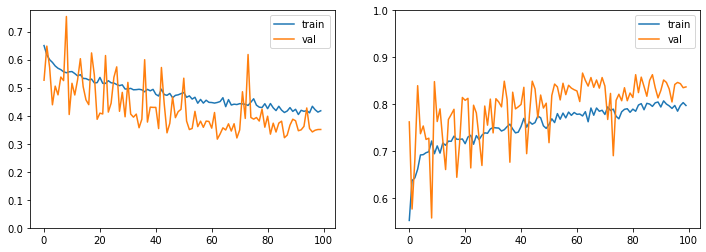

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5811 - accuracy: 0.5187 - precision: 0.9564 - recall: 0.4750 - f1: 0.6261 - specificity: 0.8276 - negative_predictive_value: 0.1721 - matthews_correlation_coefficient: 0.1958 - val_loss: 0.6641 - val_accuracy: 0.4822 - val_precision: 0.9563 - val_recall: 0.4120 - val_f1: 0.5701 - val_specificity: 0.9018 - val_negative_predictive_value: 0.1960 - val_matthews_correlation_coefficient: 0.2191

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21914, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_21-14_57_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5623 - accuracy: 0.5078 - precision: 0.9730 - recall: 0.4623 - f1: 0.6141 - specificity: 0.8587 - negative_predictive_value: 0.1781 - matthews_correlation_coefficient: 0.2201 - val_loss: 0.5272 - val_accuracy: 0.6141 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4859 - accuracy: 0.6885 - precision: 0.9687 - recall: 0.6730 - f1: 0.7815 - specificity: 0.7945 - negative_predictive_value: 0.2647 - matthews_correlation_coefficient: 0.3227 - val_loss: 0.7323 - val_accuracy: 0.4814 - val_precision: 0.9689 - val_recall: 0.4061 - val_f1: 0.5668 - val_specificity: 0.9586 - val_negative_predictive_value: 0.2019 - val_matthews_correlation_coefficient: 0.2497

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32156
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4681 - accuracy: 0.6946 - precision: 0.9757 - recall: 0.6737 - f1: 0.7884 - specificity: 0.8379 - negative_predictive_value: 0.2660 - matthews_correlation_coefficient: 0.3440 - val_loss: 0.4070 - val_accuracy: 0.7832 - val_precision: 0.9456 - val_recall: 0.7573 - val_f1: 0.8393 - val_specificity: 0.7848 - val_negative_predictive_value: 0.3385 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4212 - accuracy: 0.7386 - precision: 0.9780 - recall: 0.7228 - f1: 0.8244 - specificity: 0.8407 - negative_predictive_value: 0.3033 - matthews_correlation_coefficient: 0.3920 - val_loss: 0.3158 - val_accuracy: 0.8361 - val_precision: 0.9290 - val_recall: 0.8326 - val_f1: 0.8768 - val_specificity: 0.6239 - val_negative_predictive_value: 0.3910 - val_matthews_correlation_coefficient: 0.3821

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.52413
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4220 - accuracy: 0.7625 - precision: 0.9694 - recall: 0.7481 - f1: 0.8352 - specificity: 0.8291 - negative_predictive_value: 0.3368 - matthews_correlation_coefficient: 0.4129 - val_loss: 0.4544 - val_accuracy: 0.7242 - val_precision: 0.9598 - val_recall: 0.6801 - val_f1: 0.7928 - val_specificity: 0.8959 - val_negative_predictive_value: 0.3037 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3851 - accuracy: 0.7727 - precision: 0.9772 - recall: 0.7636 - f1: 0.8518 - specificity: 0.8249 - negative_predictive_value: 0.3353 - matthews_correlation_coefficient: 0.4212 - val_loss: 0.3870 - val_accuracy: 0.7797 - val_precision: 0.9544 - val_recall: 0.7461 - val_f1: 0.8358 - val_specificity: 0.8423 - val_negative_predictive_value: 0.3439 - val_matthews_correlation_coefficient: 0.4135

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.52413
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3655 - accuracy: 0.7920 - precision: 0.9816 - recall: 0.7828 - f1: 0.8660 - specificity: 0.8800 - negative_predictive_value: 0.3630 - matthews_correlation_coefficient: 0.4666 - val_loss: 0.5235 - val_accuracy: 0.6930 - val_precision: 0.9623 - val_recall: 0.6427 - val_f1: 0.7670 - val_specificity: 0.9243 - val_negative_predictive_value: 0.2882 - val_matthews_correlation_coefficie

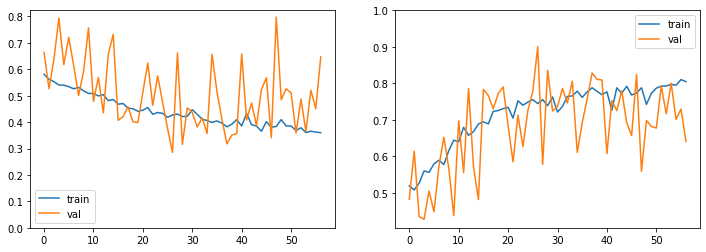

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5721 - accuracy: 0.6555 - precision: 0.9141 - recall: 0.6275 - f1: 0.7321 - specificity: 0.7511 - negative_predictive_value: 0.3367 - matthews_correlation_coefficient: 0.3141 - val_loss: 0.6090 - val_accuracy: 0.7060 - val_precision: 0.8701 - val_recall: 0.7031 - val_f1: 0.7738 - val_specificity: 0.6340 - val_negative_predictive_value: 0.3594 - val_matthews_correlation_coefficient: 0.3035

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30350, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_21-15_06_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5602 - accuracy: 0.6905 - precision: 0.9190 - recall: 0.6768 - f1: 0.7707 - specificity: 0.7350 - negative_predictive_value: 0.3651 - matthews_correlation_coefficient: 0.3394 - val_loss: 0.6318 - val_accuracy: 0.6531 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5120 - accuracy: 0.7156 - precision: 0.9284 - recall: 0.7024 - f1: 0.7936 - specificity: 0.7740 - negative_predictive_value: 0.3963 - matthews_correlation_coefficient: 0.3905 - val_loss: 0.5483 - val_accuracy: 0.6817 - val_precision: 0.9095 - val_recall: 0.6826 - val_f1: 0.7750 - val_specificity: 0.7014 - val_negative_predictive_value: 0.3458 - val_matthews_correlation_coefficient: 0.3114

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37083
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5078 - accuracy: 0.7260 - precision: 0.9275 - recall: 0.7170 - f1: 0.8014 - specificity: 0.7513 - negative_predictive_value: 0.4059 - matthews_correlation_coefficient: 0.3918 - val_loss: 0.6271 - val_accuracy: 0.6834 - val_precision: 0.8981 - val_recall: 0.6463 - val_f1: 0.7463 - val_specificity: 0.7631 - val_negative_predictive_value: 0.3581 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39969
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4936 - accuracy: 0.7395 - precision: 0.9315 - recall: 0.7327 - f1: 0.8129 - specificity: 0.7694 - negative_predictive_value: 0.4253 - matthews_correlation_coefficient: 0.4198 - val_loss: 0.5066 - val_accuracy: 0.7459 - val_precision: 0.9153 - val_recall: 0.7620 - val_f1: 0.8284 - val_specificity: 0.6984 - val_negative_predictive_value: 0.4144 - val_matthews_correlation_coefficient: 0.3873

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.39969
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4832 - accuracy: 0.7423 - precision: 0.9303 - recall: 0.7348 - f1: 0.8156 - specificity: 0.7583 - negative_predictive_value: 0.4187 - matthews_correlation_coefficient: 0.4127 - val_loss: 0.4656 - val_accuracy: 0.7467 - val_precision: 0.9037 - val_recall: 0.7732 - val_f1: 0.8309 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39969
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4640 - accuracy: 0.7521 - precision: 0.9341 - recall: 0.7443 - f1: 0.8222 - specificity: 0.7784 - negative_predictive_value: 0.4383 - matthews_correlation_coefficient: 0.4377 - val_loss: 0.5100 - val_accuracy: 0.7641 - val_precision: 0.9226 - val_recall: 0.7795 - val_f1: 0.8417 - val_specificity: 0.7242 - val_negative_predictive_value: 0.4383 - val_matthews_correlation_coefficient: 0.4238

Epoch 00045: val_matthews_correlation_coefficient improved from 0.39969 to 0.42379, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_21-15_06_10.h5
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4707 - accuracy: 0.7521 - precision: 0.9316 - recall: 0.7506 - f1: 0.8239 - specificity: 0.7579 - negative_predictive_value: 0.4390 - matthews_correlation_coefficient: 0.4274 - val_


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42379
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4497 - accuracy: 0.7787 - precision: 0.9359 - recall: 0.7831 - f1: 0.8474 - specificity: 0.7660 - negative_predictive_value: 0.4746 - matthews_correlation_coefficient: 0.4691 - val_loss: 0.5981 - val_accuracy: 0.6817 - val_precision: 0.9388 - val_recall: 0.6573 - val_f1: 0.7677 - val_specificity: 0.8146 - val_negative_predictive_value: 0.3616 - val_matthews_correlation_coefficient: 0.3744

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.42379
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4545 - accuracy: 0.7631 - precision: 0.9352 - recall: 0.7600 - f1: 0.8326 - specificity: 0.7853 - negative_predictive_value: 0.4558 - matthews_correlation_coefficient: 0.4564 - val_loss: 0.4295 - val_accuracy: 0.8014 - val_precision: 0.9028 - val_recall: 0.8515 - val_f1: 0.8743 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.43428
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4556 - accuracy: 0.7683 - precision: 0.9369 - recall: 0.7646 - f1: 0.8341 - specificity: 0.7878 - negative_predictive_value: 0.4768 - matthews_correlation_coefficient: 0.4731 - val_loss: 0.5869 - val_accuracy: 0.6704 - val_precision: 0.9456 - val_recall: 0.6380 - val_f1: 0.7551 - val_specificity: 0.8351 - val_negative_predictive_value: 0.3576 - val_matthews_correlation_coefficient: 0.3767

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.43428
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4445 - accuracy: 0.7727 - precision: 0.9383 - recall: 0.7704 - f1: 0.8406 - specificity: 0.7843 - negative_predictive_value: 0.4719 - matthews_correlation_coefficient: 0.4707 - val_loss: 0.5766 - val_accuracy: 0.6635 - val_precision: 0.9512 - val_recall: 0.6247 - val_f1: 0.7478 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4343 - accuracy: 0.7809 - precision: 0.9334 - recall: 0.7719 - f1: 0.8392 - specificity: 0.7909 - negative_predictive_value: 0.4771 - matthews_correlation_coefficient: 0.4806 - val_loss: 0.5476 - val_accuracy: 0.7199 - val_precision: 0.9470 - val_recall: 0.7003 - val_f1: 0.8002 - val_specificity: 0.8225 - val_negative_predictive_value: 0.3968 - val_matthews_correlation_coefficient: 0.4217

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.49392
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4337 - accuracy: 0.7796 - precision: 0.9381 - recall: 0.7775 - f1: 0.8449 - specificity: 0.7834 - negative_predictive_value: 0.4755 - matthews_correlation_coefficient: 0.4781 - val_loss: 0.5369 - val_accuracy: 0.7008 - val_precision: 0.9467 - val_recall: 0.6778 - val_f1: 0.7846 - val_specificity: 0.8219 - val_negative_predictive_value: 0.3797 - val_matthews_correlation_coefficie

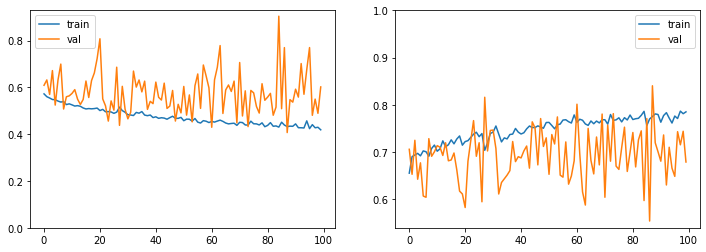

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6421 - accuracy: 0.8121 - precision: 0.9977 - recall: 0.8148 - f1: 0.8840 - specificity: 0.0483 - negative_predictive_value: 0.0042 - matthews_correlation_coefficient: 0.0097 - val_loss: 0.0459 - val_accuracy: 0.9965 - val_precision: 0.9966 - val_recall: 1.0000 - val_f1: 0.9983 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_21-15_21_07.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.8358 - accuracy: 0.5935 - precision: 0.9978 - recall: 0.5936 - f1: 0.6948 - specificity: 0.0552 - negative_predictive_value: 0.0031 - matthews_correlation_coefficient: 0.0064 - val_loss: 0.6986 - val_accuracy: 0.506

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4785 - accuracy: 0.7531 - precision: 0.9990 - recall: 0.7516 - f1: 0.8534 - specificity: 0.0828 - negative_predictive_value: 0.0149 - matthews_correlation_coefficient: 0.0277 - val_loss: 0.3613 - val_accuracy: 0.8109 - val_precision: 0.9990 - val_recall: 0.8160 - val_f1: 0.8965 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0107 - val_matthews_correlation_coefficient: 0.0238

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.03033
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4799 - accuracy: 0.7993 - precision: 0.9988 - recall: 0.7977 - f1: 0.8811 - specificity: 0.0828 - negative_predictive_value: 0.0123 - matthews_correlation_coefficient: 0.0254 - val_loss: 0.7726 - val_accuracy: 0.5629 - val_precision: 0.9986 - val_recall: 0.5737 - val_f1: 0.7221 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0056 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4443 - accuracy: 0.8028 - precision: 0.9988 - recall: 0.8044 - f1: 0.8778 - specificity: 0.0828 - negative_predictive_value: 0.0218 - matthews_correlation_coefficient: 0.0311 - val_loss: 0.5349 - val_accuracy: 0.7051 - val_precision: 0.9987 - val_recall: 0.7126 - val_f1: 0.8281 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0075 - val_matthews_correlation_coefficient: 0.0168

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.05318
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4140 - accuracy: 0.7547 - precision: 0.9992 - recall: 0.7559 - f1: 0.8565 - specificity: 0.0897 - negative_predictive_value: 0.0169 - matthews_correlation_coefficient: 0.0293 - val_loss: 0.3042 - val_accuracy: 0.8630 - val_precision: 0.9991 - val_recall: 0.8670 - val_f1: 0.9269 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0183 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.05553
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3786 - accuracy: 0.7764 - precision: 0.9992 - recall: 0.7777 - f1: 0.8661 - specificity: 0.0931 - negative_predictive_value: 0.0171 - matthews_correlation_coefficient: 0.0330 - val_loss: 0.2117 - val_accuracy: 0.9809 - val_precision: 0.9983 - val_recall: 0.9831 - val_f1: 0.9905 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0541 - val_matthews_correlation_coefficient: 0.0541

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.05553
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3547 - accuracy: 0.8579 - precision: 0.9991 - recall: 0.8560 - f1: 0.9173 - specificity: 0.0897 - negative_predictive_value: 0.0260 - matthews_correlation_coefficient: 0.0419 - val_loss: 0.4792 - val_accuracy: 0.7528 - val_precision: 0.9988 - val_recall: 0.7592 - val_f1: 0.8600 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.05553
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3888 - accuracy: 0.8178 - precision: 0.9993 - recall: 0.8191 - f1: 0.8973 - specificity: 0.0966 - negative_predictive_value: 0.0236 - matthews_correlation_coefficient: 0.0406 - val_loss: 0.7518 - val_accuracy: 0.6583 - val_precision: 0.9987 - val_recall: 0.6669 - val_f1: 0.7951 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0070 - val_matthews_correlation_coefficient: 0.0157

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.05553
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2901 - accuracy: 0.8839 - precision: 0.9995 - recall: 0.8847 - f1: 0.9362 - specificity: 0.1034 - negative_predictive_value: 0.0296 - matthews_correlation_coefficient: 0.0488 - val_loss: 0.4048 - val_accuracy: 0.7762 - val_precision: 0.9990 - val_recall: 0.7822 - val_f1: 0.8741 - val_spe

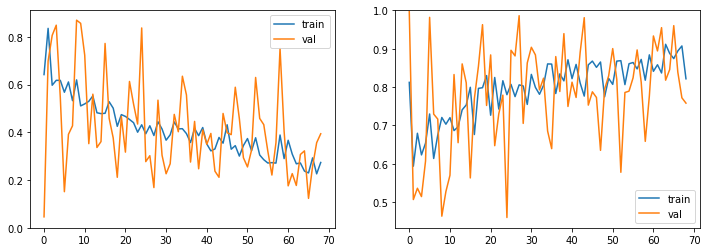

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6116 - accuracy: 0.5512 - precision: 0.9362 - recall: 0.4898 - f1: 0.6235 - specificity: 0.8199 - negative_predictive_value: 0.2650 - matthews_correlation_coefficient: 0.2500 - val_loss: 0.5131 - val_accuracy: 0.6826 - val_precision: 0.8537 - val_recall: 0.6947 - val_f1: 0.7618 - val_specificity: 0.5573 - val_negative_predictive_value: 0.3100 - val_matthews_correlation_coefficient: 0.2290

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22903, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_21-15_31_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5943 - accuracy: 0.5315 - precision: 0.9480 - recall: 0.4532 - f1: 0.6022 - specificity: 0.8650 - negative_predictive_value: 0.2708 - matthews_correlation_coefficient: 0.2628 - val_loss: 0.6094 - val_accuracy: 0.4961 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34906
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5343 - accuracy: 0.6538 - precision: 0.9436 - recall: 0.6145 - f1: 0.7353 - specificity: 0.8128 - negative_predictive_value: 0.3335 - matthews_correlation_coefficient: 0.3417 - val_loss: 0.5591 - val_accuracy: 0.6557 - val_precision: 0.9378 - val_recall: 0.6299 - val_f1: 0.7485 - val_specificity: 0.7818 - val_negative_predictive_value: 0.3272 - val_matthews_correlation_coefficient: 0.3288

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34906
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5280 - accuracy: 0.6625 - precision: 0.9470 - recall: 0.6250 - f1: 0.7472 - specificity: 0.8549 - negative_predictive_value: 0.3488 - matthews_correlation_coefficient: 0.3727 - val_loss: 0.7233 - val_accuracy: 0.5291 - val_precision: 0.9561 - val_recall: 0.4170 - val_f1: 0.5755 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4855 - accuracy: 0.7115 - precision: 0.9512 - recall: 0.6791 - f1: 0.7865 - specificity: 0.8309 - negative_predictive_value: 0.3788 - matthews_correlation_coefficient: 0.4072 - val_loss: 0.5066 - val_accuracy: 0.7016 - val_precision: 0.9304 - val_recall: 0.6476 - val_f1: 0.7585 - val_specificity: 0.8397 - val_negative_predictive_value: 0.3782 - val_matthews_correlation_coefficient: 0.4135

Epoch 00029: val_matthews_correlation_coefficient improved from 0.39525 to 0.41350, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_21-15_31_34.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4837 - accuracy: 0.7054 - precision: 0.9535 - recall: 0.6709 - f1: 0.7814 - specificity: 0.8384 - negative_predictive_value: 0.3724 - matthews_correlation_coefficient: 0.4047 - val_loss: 0.4785 - val_accuracy: 0.6921 - val_precision: 0.9428 - val_recall: 0.6743 - val_f1: 0.7798 - 


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.41503
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4715 - accuracy: 0.7130 - precision: 0.9488 - recall: 0.6850 - f1: 0.7906 - specificity: 0.8223 - negative_predictive_value: 0.3771 - matthews_correlation_coefficient: 0.4045 - val_loss: 0.6292 - val_accuracy: 0.5993 - val_precision: 0.9456 - val_recall: 0.5100 - val_f1: 0.6567 - val_specificity: 0.9046 - val_negative_predictive_value: 0.3083 - val_matthews_correlation_coefficient: 0.3504

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41503
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4726 - accuracy: 0.7180 - precision: 0.9533 - recall: 0.6874 - f1: 0.7930 - specificity: 0.8385 - negative_predictive_value: 0.3910 - matthews_correlation_coefficient: 0.4232 - val_loss: 0.5413 - val_accuracy: 0.6774 - val_precision: 0.9332 - val_recall: 0.6167 - val_f1: 0.7368 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4498 - accuracy: 0.7273 - precision: 0.9628 - recall: 0.6935 - f1: 0.8010 - specificity: 0.8603 - negative_predictive_value: 0.3997 - matthews_correlation_coefficient: 0.4448 - val_loss: 0.4518 - val_accuracy: 0.7251 - val_precision: 0.9016 - val_recall: 0.7038 - val_f1: 0.7854 - val_specificity: 0.7234 - val_negative_predictive_value: 0.3909 - val_matthews_correlation_coefficient: 0.3787

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43560
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4504 - accuracy: 0.7293 - precision: 0.9488 - recall: 0.7049 - f1: 0.8029 - specificity: 0.8385 - negative_predictive_value: 0.3996 - matthews_correlation_coefficient: 0.4333 - val_loss: 0.5975 - val_accuracy: 0.6357 - val_precision: 0.9395 - val_recall: 0.5591 - val_f1: 0.6957 - val_specificity: 0.8823 - val_negative_predictive_value: 0.3280 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4391 - accuracy: 0.7531 - precision: 0.9559 - recall: 0.7301 - f1: 0.8237 - specificity: 0.8567 - negative_predictive_value: 0.4232 - matthews_correlation_coefficient: 0.4655 - val_loss: 0.6606 - val_accuracy: 0.6193 - val_precision: 0.9515 - val_recall: 0.5294 - val_f1: 0.6751 - val_specificity: 0.9224 - val_negative_predictive_value: 0.3236 - val_matthews_correlation_coefficient: 0.3783

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.44674
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4414 - accuracy: 0.7382 - precision: 0.9515 - recall: 0.7168 - f1: 0.8127 - specificity: 0.8273 - negative_predictive_value: 0.4093 - matthews_correlation_coefficient: 0.4403 - val_loss: 0.6182 - val_accuracy: 0.6297 - val_precision: 0.9406 - val_recall: 0.5513 - val_f1: 0.6891 - val_specificity: 0.8840 - val_negative_predictive_value: 0.3257 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4434 - accuracy: 0.7410 - precision: 0.9563 - recall: 0.7146 - f1: 0.8113 - specificity: 0.8401 - negative_predictive_value: 0.4152 - matthews_correlation_coefficient: 0.4514 - val_loss: 0.6372 - val_accuracy: 0.6201 - val_precision: 0.9449 - val_recall: 0.5365 - val_f1: 0.6780 - val_specificity: 0.9011 - val_negative_predictive_value: 0.3215 - val_matthews_correlation_coefficient: 0.3673

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.44674
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4239 - accuracy: 0.7410 - precision: 0.9617 - recall: 0.7133 - f1: 0.8148 - specificity: 0.8735 - negative_predictive_value: 0.4124 - matthews_correlation_coefficient: 0.4622 - val_loss: 0.5134 - val_accuracy: 0.7069 - val_precision: 0.9384 - val_recall: 0.6481 - val_f1: 0.7620 - val_specificity: 0.8688 - val_negative_predictive_value: 0.3846 - val_matthews_correlation_coefficie

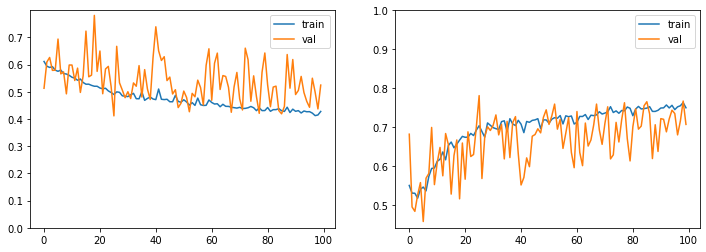

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6046 - accuracy: 0.6106 - precision: 0.9350 - recall: 0.5969 - f1: 0.7107 - specificity: 0.7096 - negative_predictive_value: 0.2155 - matthews_correlation_coefficient: 0.2173 - val_loss: 0.5481 - val_accuracy: 0.6088 - val_precision: 0.9198 - val_recall: 0.5626 - val_f1: 0.6934 - val_specificity: 0.7934 - val_negative_predictive_value: 0.2534 - val_matthews_correlation_coefficient: 0.2450

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24502, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_21-15_46_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5526 - accuracy: 0.6488 - precision: 0.9392 - recall: 0.6262 - f1: 0.7419 - specificity: 0.7597 - negative_predictive_value: 0.2541 - matthews_correlation_coefficient: 0.2749 - val_loss: 0.6108 - val_accuracy: 0.5993 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient improved from 0.32071 to 0.34836, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_21-15_46_37.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4810 - accuracy: 0.7345 - precision: 0.9593 - recall: 0.7258 - f1: 0.8202 - specificity: 0.8045 - negative_predictive_value: 0.3244 - matthews_correlation_coefficient: 0.3808 - val_loss: 0.4376 - val_accuracy: 0.7520 - val_precision: 0.9188 - val_recall: 0.7336 - val_f1: 0.8132 - val_specificity: 0.7188 - val_negative_predictive_value: 0.3489 - val_matthews_correlation_coefficient: 0.3454

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34836
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4706 - accuracy: 0.7362 - precision: 0.9617 - recall: 0.7263 - f1: 0.8218 - specificity: 0.7992 - negative_predictive_value: 0.3307 - matthews_correlation_coefficient: 0.3872 - val_loss: 0.4562 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5050 - accuracy: 0.6560 - precision: 0.9690 - recall: 0.6267 - f1: 0.7432 - specificity: 0.8617 - negative_predictive_value: 0.2927 - matthews_correlation_coefficient: 0.3508 - val_loss: 0.4860 - val_accuracy: 0.7251 - val_precision: 0.9267 - val_recall: 0.6963 - val_f1: 0.7924 - val_specificity: 0.7458 - val_negative_predictive_value: 0.3042 - val_matthews_correlation_coefficient: 0.3454

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40678
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4632 - accuracy: 0.7386 - precision: 0.9590 - recall: 0.7313 - f1: 0.8235 - specificity: 0.7633 - negative_predictive_value: 0.3304 - matthews_correlation_coefficient: 0.3750 - val_loss: 0.3822 - val_accuracy: 0.8031 - val_precision: 0.9102 - val_recall: 0.8067 - val_f1: 0.8536 - val_specificity: 0.6106 - val_negative_predictive_value: 0.3659 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4339 - accuracy: 0.7685 - precision: 0.9630 - recall: 0.7643 - f1: 0.8477 - specificity: 0.8136 - negative_predictive_value: 0.3621 - matthews_correlation_coefficient: 0.4241 - val_loss: 0.4156 - val_accuracy: 0.7780 - val_precision: 0.9175 - val_recall: 0.7678 - val_f1: 0.8340 - val_specificity: 0.6809 - val_negative_predictive_value: 0.3424 - val_matthews_correlation_coefficient: 0.3669

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40678
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4331 - accuracy: 0.7581 - precision: 0.9643 - recall: 0.7502 - f1: 0.8391 - specificity: 0.8144 - negative_predictive_value: 0.3605 - matthews_correlation_coefficient: 0.4232 - val_loss: 0.3940 - val_accuracy: 0.7936 - val_precision: 0.9245 - val_recall: 0.7810 - val_f1: 0.8444 - val_specificity: 0.7113 - val_negative_predictive_value: 0.3696 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4220 - accuracy: 0.7725 - precision: 0.9663 - recall: 0.7640 - f1: 0.8474 - specificity: 0.8181 - negative_predictive_value: 0.3674 - matthews_correlation_coefficient: 0.4322 - val_loss: 0.3817 - val_accuracy: 0.8014 - val_precision: 0.9244 - val_recall: 0.7892 - val_f1: 0.8500 - val_specificity: 0.7406 - val_negative_predictive_value: 0.4052 - val_matthews_correlation_coefficient: 0.4149

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.43458
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4121 - accuracy: 0.7787 - precision: 0.9682 - recall: 0.7701 - f1: 0.8526 - specificity: 0.8276 - negative_predictive_value: 0.3758 - matthews_correlation_coefficient: 0.4426 - val_loss: 0.3541 - val_accuracy: 0.8170 - val_precision: 0.9040 - val_recall: 0.8299 - val_f1: 0.8637 - val_specificity: 0.5910 - val_negative_predictive_value: 0.4124 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.45786
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4096 - accuracy: 0.7690 - precision: 0.9653 - recall: 0.7614 - f1: 0.8446 - specificity: 0.8203 - negative_predictive_value: 0.3679 - matthews_correlation_coefficient: 0.4364 - val_loss: 0.4959 - val_accuracy: 0.7346 - val_precision: 0.9496 - val_recall: 0.6895 - val_f1: 0.7967 - val_specificity: 0.8902 - val_negative_predictive_value: 0.3506 - val_matthews_correlation_coefficient: 0.4144

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45786
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4763 - accuracy: 0.7464 - precision: 0.9595 - recall: 0.7397 - f1: 0.8265 - specificity: 0.7889 - negative_predictive_value: 0.3490 - matthews_correlation_coefficient: 0.3984 - val_loss: 0.3667 - val_accuracy: 0.8170 - val_precision: 0.9264 - val_recall: 0.8063 - val_f1: 0.8604 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.46232
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3943 - accuracy: 0.8004 - precision: 0.9716 - recall: 0.7950 - f1: 0.8687 - specificity: 0.8245 - negative_predictive_value: 0.4232 - matthews_correlation_coefficient: 0.4822 - val_loss: 0.3861 - val_accuracy: 0.7953 - val_precision: 0.9103 - val_recall: 0.7968 - val_f1: 0.8483 - val_specificity: 0.6284 - val_negative_predictive_value: 0.3500 - val_matthews_correlation_coefficient: 0.3574

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46232
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3682 - accuracy: 0.8089 - precision: 0.9713 - recall: 0.8049 - f1: 0.8770 - specificity: 0.8444 - negative_predictive_value: 0.4292 - matthews_correlation_coefficient: 0.5023 - val_loss: 0.3796 - val_accuracy: 0.7997 - val_precision: 0.9400 - val_recall: 0.7735 - val_f1: 0.8460 - val_spe

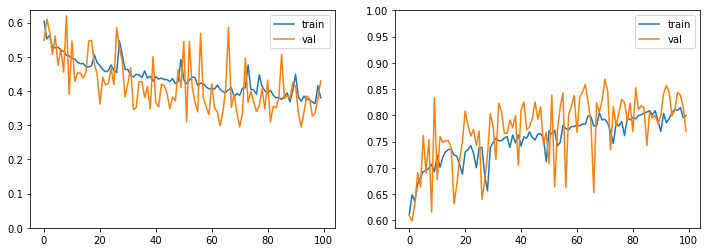

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4292 - accuracy: 0.7748 - precision: 0.9920 - recall: 0.7643 - f1: 0.8571 - specificity: 0.8038 - negative_predictive_value: 0.2169 - matthews_correlation_coefficient: 0.3453 - val_loss: 0.4398 - val_accuracy: 0.7910 - val_precision: 0.9633 - val_recall: 0.7637 - val_f1: 0.8506 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2072 - val_matthews_correlation_coefficient: 0.3304

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.33043, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_21-16_01_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3373 - accuracy: 0.8594 - precision: 0.9910 - recall: 0.8563 - f1: 0.9169 - specificity: 0.7120 - negative_predictive_value: 0.2928 - matthews_correlation_coefficient: 0.3992 - val_loss: 0.3833 - val_accuracy: 0.8404 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.57116
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2654 - accuracy: 0.9113 - precision: 0.9927 - recall: 0.9129 - f1: 0.9500 - specificity: 0.7937 - negative_predictive_value: 0.4265 - matthews_correlation_coefficient: 0.5364 - val_loss: 0.2327 - val_accuracy: 0.9237 - val_precision: 0.9641 - val_recall: 0.9029 - val_f1: 0.9320 - val_specificity: 0.7613 - val_negative_predictive_value: 0.4090 - val_matthews_correlation_coefficient: 0.5184

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.57116
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2641 - accuracy: 0.9078 - precision: 0.9905 - recall: 0.9110 - f1: 0.9481 - specificity: 0.7724 - negative_predictive_value: 0.3992 - matthews_correlation_coefficient: 0.5059 - val_loss: 0.1844 - val_accuracy: 0.9402 - val_precision: 0.9634 - val_recall: 0.9209 - val_f1: 0.9413 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2370 - accuracy: 0.9197 - precision: 0.9921 - recall: 0.9193 - f1: 0.9527 - specificity: 0.7433 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5445 - val_loss: 0.1499 - val_accuracy: 0.9627 - val_precision: 0.9637 - val_recall: 0.9444 - val_f1: 0.9537 - val_specificity: 0.7523 - val_negative_predictive_value: 0.6171 - val_matthews_correlation_coefficient: 0.6528

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59954 to 0.65276, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_21-16_01_35.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9265 - precision: 0.9917 - recall: 0.9299 - f1: 0.9587 - specificity: 0.7759 - negative_predictive_value: 0.4886 - matthews_correlation_coefficient: 0.5693 - val_loss: 0.3722 - val_accuracy: 0.8820 - val_precision: 0.9688 - val_recall: 0.8548 - val_f1: 0.9073 - val_s


Epoch 00043: val_matthews_correlation_coefficient improved from 0.66815 to 0.68802, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_21-16_01_35.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2111 - accuracy: 0.9323 - precision: 0.9927 - recall: 0.9322 - f1: 0.9599 - specificity: 0.7687 - negative_predictive_value: 0.4926 - matthews_correlation_coefficient: 0.5739 - val_loss: 0.1289 - val_accuracy: 0.9636 - val_precision: 0.9637 - val_recall: 0.9454 - val_f1: 0.9542 - val_specificity: 0.7523 - val_negative_predictive_value: 0.6320 - val_matthews_correlation_coefficient: 0.6614

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.68802
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2141 - accuracy: 0.9360 - precision: 0.9933 - recall: 0.9387 - f1: 0.9643 - specificity: 0.7959 - negative_predictive_value: 0.5127 - matthews_correlation_coefficient: 0.5987 - val_loss: 0.2048


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.68802
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1828 - accuracy: 0.9564 - precision: 0.9939 - recall: 0.9599 - f1: 0.9761 - specificity: 0.8308 - negative_predictive_value: 0.6081 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.3602 - val_accuracy: 0.8656 - val_precision: 0.9698 - val_recall: 0.8369 - val_f1: 0.8975 - val_specificity: 0.8333 - val_negative_predictive_value: 0.2993 - val_matthews_correlation_coefficient: 0.4462

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.68802
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1759 - accuracy: 0.9460 - precision: 0.9913 - recall: 0.9482 - f1: 0.9679 - specificity: 0.8260 - negative_predictive_value: 0.5495 - matthews_correlation_coefficient: 0.6349 - val_loss: 0.2828 - val_accuracy: 0.8899 - val_precision: 0.9698 - val_recall: 0.8622 - val_f1: 0.9119 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.69994
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1696 - accuracy: 0.9445 - precision: 0.9946 - recall: 0.9462 - f1: 0.9687 - specificity: 0.8250 - negative_predictive_value: 0.5803 - matthews_correlation_coefficient: 0.6505 - val_loss: 0.4880 - val_accuracy: 0.8179 - val_precision: 0.9705 - val_recall: 0.7861 - val_f1: 0.8674 - val_specificity: 0.8468 - val_negative_predictive_value: 0.2411 - val_matthews_correlation_coefficient: 0.3923

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.69994
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1580 - accuracy: 0.9527 - precision: 0.9950 - recall: 0.9547 - f1: 0.9737 - specificity: 0.8322 - negative_predictive_value: 0.6107 - matthews_correlation_coefficient: 0.6796 - val_loss: 0.1280 - val_accuracy: 0.9584 - val_precision: 0.9665 - val_recall: 0.9368 - val_f1: 0.9510 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.72160
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1485 - accuracy: 0.9592 - precision: 0.9960 - recall: 0.9610 - f1: 0.9776 - specificity: 0.7969 - negative_predictive_value: 0.6086 - matthews_correlation_coefficient: 0.6680 - val_loss: 0.8666 - val_accuracy: 0.7884 - val_precision: 0.9705 - val_recall: 0.7558 - val_f1: 0.8483 - val_specificity: 0.8468 - val_negative_predictive_value: 0.2169 - val_matthews_correlation_coefficient: 0.3623

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.72160
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1818 - accuracy: 0.9373 - precision: 0.9951 - recall: 0.9348 - f1: 0.9624 - specificity: 0.8006 - negative_predictive_value: 0.5266 - matthews_correlation_coefficient: 0.6086 - val_loss: 0.1933 - val_accuracy: 0.9245 - val_precision: 0.9682 - val_recall: 0.9005 - val_f1: 0.9326 - val_spe

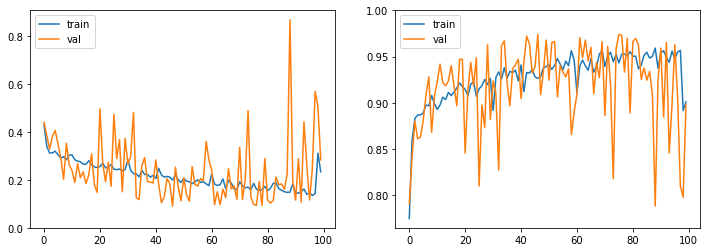

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5902 - accuracy: 0.6592 - precision: 0.9067 - recall: 0.6298 - f1: 0.7325 - specificity: 0.7612 - negative_predictive_value: 0.3726 - matthews_correlation_coefficient: 0.3330 - val_loss: 0.5139 - val_accuracy: 0.7398 - val_precision: 0.8854 - val_recall: 0.7720 - val_f1: 0.8224 - val_specificity: 0.6221 - val_negative_predictive_value: 0.4347 - val_matthews_correlation_coefficient: 0.3540

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35397, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_21-16_16_33.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5647 - accuracy: 0.6861 - precision: 0.9086 - recall: 0.6643 - f1: 0.7594 - specificity: 0.7605 - negative_predictive_value: 0.4030 - matthews_correlation_coefficient: 0.3613 - val_loss: 0.6569 - val_accuracy: 0.6253 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5188 - accuracy: 0.7232 - precision: 0.9145 - recall: 0.6991 - f1: 0.7882 - specificity: 0.7938 - negative_predictive_value: 0.4424 - matthews_correlation_coefficient: 0.4227 - val_loss: 0.5586 - val_accuracy: 0.7242 - val_precision: 0.9111 - val_recall: 0.7228 - val_f1: 0.8006 - val_specificity: 0.7233 - val_negative_predictive_value: 0.4333 - val_matthews_correlation_coefficient: 0.3906

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40189
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5247 - accuracy: 0.7282 - precision: 0.9104 - recall: 0.7226 - f1: 0.8003 - specificity: 0.7566 - negative_predictive_value: 0.4578 - matthews_correlation_coefficient: 0.4175 - val_loss: 0.5547 - val_accuracy: 0.7155 - val_precision: 0.9227 - val_recall: 0.6999 - val_f1: 0.7906 - val_specificity: 0.7590 - val_negative_predictive_value: 0.4258 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40808
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5022 - accuracy: 0.7436 - precision: 0.9115 - recall: 0.7292 - f1: 0.8054 - specificity: 0.7680 - negative_predictive_value: 0.4647 - matthews_correlation_coefficient: 0.4365 - val_loss: 0.4884 - val_accuracy: 0.7251 - val_precision: 0.8983 - val_recall: 0.7328 - val_f1: 0.8038 - val_specificity: 0.6895 - val_negative_predictive_value: 0.4322 - val_matthews_correlation_coefficient: 0.3723

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.40808
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7427 - precision: 0.9103 - recall: 0.7308 - f1: 0.8064 - specificity: 0.7771 - negative_predictive_value: 0.4661 - matthews_correlation_coefficient: 0.4355 - val_loss: 0.5524 - val_accuracy: 0.7095 - val_precision: 0.9103 - val_recall: 0.7001 - val_f1: 0.7866 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40808
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4959 - accuracy: 0.7486 - precision: 0.9214 - recall: 0.7378 - f1: 0.8155 - specificity: 0.8013 - negative_predictive_value: 0.4716 - matthews_correlation_coefficient: 0.4557 - val_loss: 0.6500 - val_accuracy: 0.6574 - val_precision: 0.9147 - val_recall: 0.5797 - val_f1: 0.7042 - val_specificity: 0.8340 - val_negative_predictive_value: 0.3793 - val_matthews_correlation_coefficient: 0.3746

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.40808
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4926 - accuracy: 0.7373 - precision: 0.9128 - recall: 0.7177 - f1: 0.7990 - specificity: 0.7966 - negative_predictive_value: 0.4623 - matthews_correlation_coefficient: 0.4380 - val_loss: 0.5450 - val_accuracy: 0.7199 - val_precision: 0.9157 - val_recall: 0.7115 - val_f1: 0.7965 - val_spe

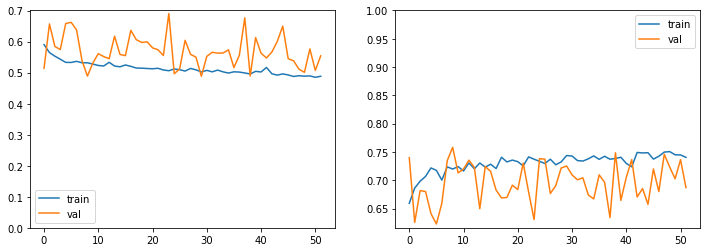

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4325 - accuracy: 0.7779 - precision: 0.9968 - recall: 0.7753 - f1: 0.8656 - specificity: 0.3069 - negative_predictive_value: 0.0507 - matthews_correlation_coefficient: 0.1011 - val_loss: 0.6438 - val_accuracy: 0.7103 - val_precision: 0.9977 - val_recall: 0.7161 - val_f1: 0.8294 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0431 - val_matthews_correlation_coefficient: 0.0888

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.08884, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_21-16_24_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3582 - accuracy: 0.8258 - precision: 0.9985 - recall: 0.8262 - f1: 0.9023 - specificity: 0.2989 - negative_predictive_value: 0.0646 - matthews_correlation_coefficient: 0.1212 - val_loss: 0.2363 - val_accuracy: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.13305
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3071 - accuracy: 0.8393 - precision: 0.9988 - recall: 0.8394 - f1: 0.9109 - specificity: 0.3069 - negative_predictive_value: 0.0713 - matthews_correlation_coefficient: 0.1305 - val_loss: 0.4445 - val_accuracy: 0.8153 - val_precision: 0.9980 - val_recall: 0.8197 - val_f1: 0.8978 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0627 - val_matthews_correlation_coefficient: 0.1167

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.13305
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3165 - accuracy: 0.8234 - precision: 0.9990 - recall: 0.8232 - f1: 0.9001 - specificity: 0.3345 - negative_predictive_value: 0.0686 - matthews_correlation_coefficient: 0.1335 - val_loss: 0.3130 - val_accuracy: 0.8465 - val_precision: 0.9981 - val_recall: 0.8505 - val_f1: 0.9169 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.13765
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2672 - accuracy: 0.8536 - precision: 0.9992 - recall: 0.8533 - f1: 0.9194 - specificity: 0.3448 - negative_predictive_value: 0.0785 - matthews_correlation_coefficient: 0.1480 - val_loss: 0.2894 - val_accuracy: 0.8569 - val_precision: 0.9981 - val_recall: 0.8608 - val_f1: 0.9230 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0765 - val_matthews_correlation_coefficient: 0.1331

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.13765
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2581 - accuracy: 0.8514 - precision: 0.9992 - recall: 0.8512 - f1: 0.9183 - specificity: 0.3046 - negative_predictive_value: 0.0758 - matthews_correlation_coefficient: 0.1374 - val_loss: 0.2046 - val_accuracy: 0.8855 - val_precision: 0.9981 - val_recall: 0.8890 - val_f1: 0.9394 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2448 - accuracy: 0.8653 - precision: 0.9993 - recall: 0.8651 - f1: 0.9264 - specificity: 0.3379 - negative_predictive_value: 0.0872 - matthews_correlation_coefficient: 0.1551 - val_loss: 0.2733 - val_accuracy: 0.8760 - val_precision: 0.9981 - val_recall: 0.8796 - val_f1: 0.9340 - val_specificity: 0.2838 - val_negative_predictive_value: 0.0900 - val_matthews_correlation_coefficient: 0.1470

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.15650
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2254 - accuracy: 0.8696 - precision: 0.9993 - recall: 0.8696 - f1: 0.9292 - specificity: 0.3621 - negative_predictive_value: 0.0927 - matthews_correlation_coefficient: 0.1689 - val_loss: 0.2415 - val_accuracy: 0.8820 - val_precision: 1.0000 - val_recall: 0.8837 - val_f1: 0.9372 - val_specificity: 0.3243 - val_negative_predictive_value: 0.1005 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2458 - accuracy: 0.8753 - precision: 0.9985 - recall: 0.8725 - f1: 0.9300 - specificity: 0.3103 - negative_predictive_value: 0.0844 - matthews_correlation_coefficient: 0.1467 - val_loss: 0.5361 - val_accuracy: 0.7502 - val_precision: 1.0000 - val_recall: 0.7537 - val_f1: 0.8560 - val_specificity: 0.3243 - val_negative_predictive_value: 0.0521 - val_matthews_correlation_coefficient: 0.1127

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.19040
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2192 - accuracy: 0.8688 - precision: 0.9995 - recall: 0.8685 - f1: 0.9283 - specificity: 0.3345 - negative_predictive_value: 0.0931 - matthews_correlation_coefficient: 0.1608 - val_loss: 0.2499 - val_accuracy: 0.8873 - val_precision: 1.0000 - val_recall: 0.8889 - val_f1: 0.9402 - val_specificity: 0.3243 - val_negative_predictive_value: 0.1050 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2171 - accuracy: 0.8822 - precision: 0.9993 - recall: 0.8822 - f1: 0.9361 - specificity: 0.3241 - negative_predictive_value: 0.0935 - matthews_correlation_coefficient: 0.1599 - val_loss: 0.3411 - val_accuracy: 0.8742 - val_precision: 1.0000 - val_recall: 0.8761 - val_f1: 0.9327 - val_specificity: 0.3243 - val_negative_predictive_value: 0.1002 - val_matthews_correlation_coefficient: 0.1690

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.19040
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2286 - accuracy: 0.8657 - precision: 0.9995 - recall: 0.8653 - f1: 0.9265 - specificity: 0.3069 - negative_predictive_value: 0.0844 - matthews_correlation_coefficient: 0.1451 - val_loss: 0.1965 - val_accuracy: 0.9124 - val_precision: 1.0000 - val_recall: 0.9136 - val_f1: 0.9542 - val_specificity: 0.3243 - val_negative_predictive_value: 0.1153 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.19040
Epoch 00087: early stopping

   Final Accuracy:  91.41%
  Final Precision:  99.90%
     Final Recall:  91.39%
  Final F-measure:  95.46%
Final Specificity:  93.33%
        Final NPV:  12.50%
        Final MCC:  32.42%
[[  14    1]
 [  98 1040]]
              precision    recall  f1-score   support

           0       0.12      0.93      0.22        15
           1       1.00      0.91      0.95      1138

    accuracy                           0.91      1153
   macro avg       0.56      0.92      0.59      1153
weighted avg       0.99      0.91      0.95      1153



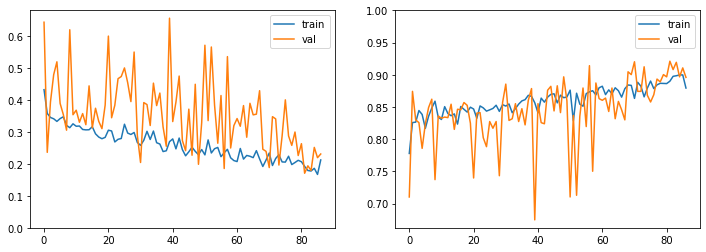

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_21-11_42_33.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_21-11_55_50.h5'
 '../models/autoencoders_requirements/ink_marked_creased_2020_03_21-12_09_28.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_21-12_18_38.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_21-12_33_19.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_21-12_40_22.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_21-12_55_03.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_21-13_09_50.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_21-13_22_09.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_21-13_36_53.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_21-13_51_38.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_21-13_58_16.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_21-14_13_07.h5'
 

In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\AR_FDB_m-026-20.png
1 of 1


[array([[0.9998161]], dtype=float32),
 array([[0.11912677]], dtype=float32),
 array([[0.730653]], dtype=float32),
 array([[9.1634305e-05]], dtype=float32),
 array([[0.47761205]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9997428]], dtype=float32),
 array([[0.9222028]], dtype=float32),
 array([[0.08804256]], dtype=float32),
 array([[0.9153787]], dtype=float32),
 array([[0.89966995]], dtype=float32),
 array([[0.00080282]], dtype=float32),
 array([[0.05625339]], dtype=float32),
 array([[0.9980715]], dtype=float32),
 array([[0.68900305]], dtype=float32),
 array([[0.049556]], dtype=float32),
 array([[0.02242593]], dtype=float32),
 array([[0.9589671]], dtype=float32),
 array([[0.01600647]], dtype=float32),
 array([[0.9998233]], dtype=float32),
 array([[0.5858977]], dtype=float32),
 array([[0.7380526]], dtype=float32),
 array([[1.]], dtype=float32)]